#### Libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg
import numpy as np
from numpy import expand_dims
import argparse
import os
import glob
import xmltodict
import xml.etree.ElementTree as ET
import xml.etree.ElementTree as ET # copy of xml
from xml.etree.ElementTree import parse
import cv2
from skimage import io
from scipy.signal import convolve2d
from PIL import Image  
import PIL 
import urllib
from urllib.request import urlopen
from typing import Tuple, List, Dict
from bs4 import BeautifulSoup
import requests
from io import BytesIO
from keras.applications import MobileNetV2
from keras import layers
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras import models
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import array_to_img
# from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator # load the image
from keras.utils.image_utils import load_img
from keras.utils.image_utils import img_to_array
from keras.utils import to_categorical
from keras import backend as K
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import seaborn as sns 

##### Warnings #####

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Data preprocessing

#### URLs for images and annotations

In [4]:
prefix_url_imgs = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/images/"
number_of_imgs = 766 # +1 to include last one (765)

list_imgs = []

for i in range(0, number_of_imgs):
    i = str(i)
    var_imgs = "BikesHelmets" + i + ".png"
    var_imgs_url = prefix_url_imgs + var_imgs
    list_imgs.append(var_imgs_url)

In [5]:
prefix_url_xml = "https://raw.githubusercontent.com/konstantinos-al/ml_project_quebec/main/Kaggle_helmets/annotations/"
number_of_annt = 766 # +1 to include last one (765)

list_annotations= []

for i in range(0, number_of_annt):
    i = str(i)
    var_annt = "BikesHelmets" + i + ".xml"
    var_annt_url = prefix_url_xml + var_annt
    list_annotations.append(var_annt_url)

### Augmentantion functions

In [6]:
def picture_zoom(image):
   # to array
   array = expand_dims(image[1], 0)
   # create image data augmentation generator
   datagen_zoom= ImageDataGenerator(zoom_range=[0.8,1.5])
   # prepare iterator
   it_zoom = datagen_zoom.flow(array, batch_size=1)
   # generate batch of images
   batch_zoom = it_zoom.next()
   # convert to unsigned integers for viewing
   image_zoom = batch_zoom[0].astype('uint64')
   # returning list
   list = [image[0], image_zoom, image[2], image[3]]
   return list

In [7]:
def picture_rotation(image):
    # to array
    array = expand_dims(image[1], 0)
    # ImageDataGenerator rotation
    datagen_rotation=ImageDataGenerator(rotation_range=45, fill_mode='nearest')
    # prepare iterator
    it_rotation = datagen_rotation.flow(array, batch_size=1)
    # generate batch of images
    batch_rotation = it_rotation.next()
    # convert to unsigned integers for viewing
    image_rotation = batch_rotation[0].astype('uint64')
    # plot raw pixel 
    img_rotation=plt.imshow(image_rotation, interpolation ='None', filternorm=True) #spline36, antialiased
    # returning list
    list = [image[0], image_rotation, image[2], image[3]]
    return list

In [8]:
def picture_brightness(image):
    # to array
    array = expand_dims(image[1], 0)
    # create image data augmentation generator
    datagen_brightness = ImageDataGenerator(brightness_range=[0.2,1.0])
    # prepare iterator
    it_brightness = datagen_brightness.flow(array, batch_size=1)
    # generate batch of images
    batch_zoom = it_brightness.next()
    # convert to unsigned integers for viewing
    image_brightness = batch_zoom[0].astype('uint64')
    # plot raw pixel 
    img_brightness=plt.imshow(image_brightness, interpolation ='None')
    # returning list
    list = [image[0], image_brightness, image[2], image[3]]
    return list

### Images load
* Retrieving and labelling images from XML annotations
* No bounding box, multiple faces per image
* For images with multiple people, if and only if all people wear helmet the label would be 1, otherwise label would be 0.

In [9]:
full_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            a = 0
            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            resized = img_temp.resize((224,224)) # resize all images to 224x224
            image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
            
            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        if i['name'] == 'With Helmet':
                            a =+1
                        else:
                            a =+0
                    if a > 0 :
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else :
                        full_imgs.append([tags['filename'], image, 0, img_path])
                
                if isinstance(tags['object'], dict):
                    if tags['object']['name'] == 'With Helmet':
                        full_imgs.append([tags['filename'], image, 1, img_path])
                    else:
                        full_imgs.append([tags['filename'], image, 0, img_path])
            else:
                pass
    except:
        pass

* Augment full images

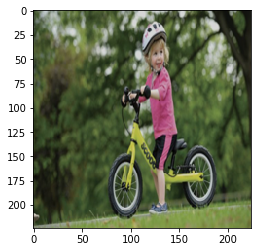

In [10]:
# Augmentantion of full images
augm_full_imgs = []
for i in range(0, len(full_imgs)):
    augm_full_imgs.append(picture_zoom(full_imgs[i]))
    augm_full_imgs.append(picture_rotation(full_imgs[i]))
    augm_full_imgs.append(picture_brightness(full_imgs[i]))

In [11]:
# consolidate initial with augmented images in one list
final_full_imgs = full_imgs + augm_full_imgs

print("Total full images:", len(final_full_imgs))
print("of which initial images:", len(full_imgs))
print("of which augmented images:", len(augm_full_imgs))

Total full images: 3044
of which initial images: 761
of which augmented images: 2283


Text(0, 0.5, 'Labels')

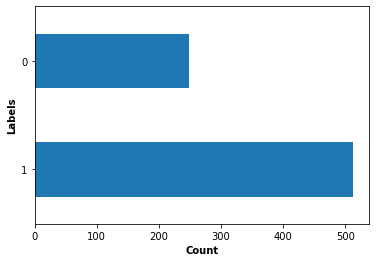

In [12]:
# Converts lists for images names and for the corresponding label names
list1=[]
list2=[]

for i in range(0,len(full_imgs)):
    list1.append(full_imgs[i][0])
    list2.append(full_imgs[i][2])
    
df=pd.DataFrame()
df=df.assign(Images=list1)
df=df.assign(Labels=list2)

df["Labels"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Labels', fontsize = 10, fontweight = 'bold')

* Transform full images to model inputs

In [13]:
# Transforming images in a proper array for model input
full_imgs_array = []
for i in range(0, len(final_full_imgs)):
    full_imgs_array.append(np.array(final_full_imgs[i][1]))
full_imgs_array = np.array(full_imgs_array, dtype='int')

In [14]:
# shape of new array
full_imgs_array.shape

(3044, 224, 224, 3)

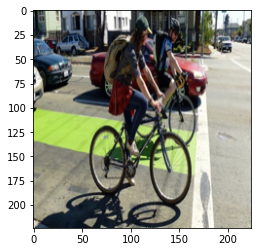

In [15]:
# testing that images appear correctly
plt.imshow(full_imgs_array[714])

In [20]:
# Creating an array with labels
labels_array = []
for i in range(0, len(final_full_imgs)):
    labels_array.append(np.array(final_full_imgs[i][2]))
labels_array = np.array(labels_array, dtype='int')

In [21]:
# Categorically encode the labels
full_imgs_labels = to_categorical(labels_array)

### Data reshaping

In [22]:
def reshape_img_input(x: np.ndarray,
                      img_rows: int = 224,
                      img_cols: int = 224,
                      normalize: bool = True) -> Tuple:
        
    print(f'Original shape of nd-array: {x.shape}')
    
    if K.image_data_format() == 'channels_first':
        
        # the channel dimension goes to the front
        x1 = x.reshape(x.shape[0], 3, img_rows, img_cols)

        input_shape = (3, img_rows, img_cols)

    else:
        # the channel dimension goes to the end. So we end up with the following 4-D tensor
        # (N-samples, Height, Width, N-channels)
        x1 = x.reshape(x.shape[0], img_rows, img_cols, 3)

        input_shape = (img_rows, img_cols, 3)

    x1 = x1.astype('float32')

    if normalize:
        x1 /= 255.
        
    return x1, input_shape

In [23]:
data, input_shape = reshape_img_input(x=full_imgs_array,
                                         img_rows=224, 
                                         img_cols=224,
                                         normalize=True)

Original shape of nd-array: (3044, 224, 224, 3)


### Train, Test & Validation split
* We now split the full dataset into train (75%) and test (25%) sets. 
* The test set is splitted again to test (25%) and validation (75%) sets.
* Random sampling is a very bad option for splitting. So, we tried stratified sampling. 
* This method splits your class proportionally between training and test set. Run oversampling, undersampling or hybrid techniques on training set.

In [24]:
#https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# split into train test sets
from sklearn.model_selection import train_test_split
X_train, X_test_1, y_train, y_test_1 = train_test_split(data, full_imgs_labels,
                                                    stratify=full_imgs_labels, 
                                                    test_size=0.25, random_state=5)

X_test, X_val, y_test, y_val = train_test_split(X_test_1, y_test_1,
                                                    stratify=y_test_1, 
                                                    test_size=0.25, random_state=5)

## Models hyperparameters

#### Universal parameters
* Setting parameters to be used across models.

In [25]:
learning_Rate = 1e-3
num_Epochs = 50
batch_Size = 32
steps_per_Epoch = int(len(X_train) / batch_Size)

### Callbacks

#### Early Stopping
* Before training the network, we define an early stopping criterion, to avoid redundent epochs once the model has already converged.

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 1, restore_best_weights = True)

#### Reduce Learning Rate On Plateau
* We define a ReduceLROnPlateau callback to reduce the learning rate when the metric we chose (val_loss) has stopped improving.

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.1, min_lr = 1e-6)

#### Saving best weights

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = '/best_model',
                                                save_best_only = True,
                                                save_weights_only = True,
                                                monitor = 'val_loss')

## Models

### Model 1 - Simple CNN
* https://github.com/mohandandamudi/FaceMaskDetection/blob/master/Face%20Mask%20Detection.ipynb

In [32]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.models import Sequential
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

* Buliding Model 

In [51]:
# Adding model layers
model_few_Layers = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(2, activation='softmax')
])
model_few_Layers.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 394272)            0         
                                                                 
 dense_6 (Dense)             (None, 2)                 788546    
                                                                 
Total params: 789,442
Trainable params: 789,442
Non-trainable params: 0
_________________________________________________________________


* Compiling Model

In [52]:
opt = optimizers.Adam(learning_rate=learning_Rate) 
model_few_Layers.compile(optimizer=opt, 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy', 'Recall', 'Precision', 'AUC']) #categorical_crossentropy or binary_crossentropy

* Fitting Model

In [53]:
model_1 = model_few_Layers.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs, # early stopping epoch: 10
                    steps_per_epoch = steps_per_Epoch, 
                    batch_size = batch_Size, 
                    verbose = 1,
                    validation_data = (X_val,y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 33s 454ms/step - loss: 2.1840 - accuracy: 0.6532 - recall: 0.6532 - precision: 0.6532 - auc: 0.6460 - val_loss: 0.5717 - val_accuracy: 0.7382 - val_recall: 0.7382 - val_precision: 0.7382 - val_auc: 0.8088 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 30s 431ms/step - loss: 0.3765 - accuracy: 0.8445 - recall: 0.8445 - precision: 0.8445 - auc: 0.9223 - val_loss: 0.4955 - val_accuracy: 0.7696 - val_recall: 0.7696 - val_precision: 0.7696 - val_auc: 0.8498 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 30s 425ms/step - loss: 0.1796 - accuracy: 0.9502 - recall: 0.9502 - precision: 0.9502 - auc: 0.9856 - val_loss: 0.5011 - val_accuracy: 0.7592 - val_recall: 0.7592 - val_precision: 0.7592 - val_auc: 0.8561 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 31s 430ms/step - loss: 0.0975 - accuracy: 0.9813 - recall: 0.9813 - precision: 0.9813 - auc: 0.9927 - val_loss: 0.8680 - val_accuracy: 0.7

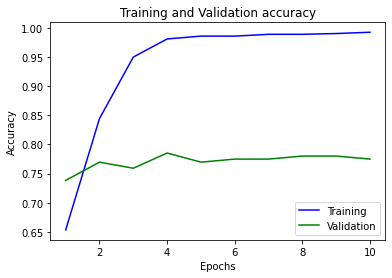

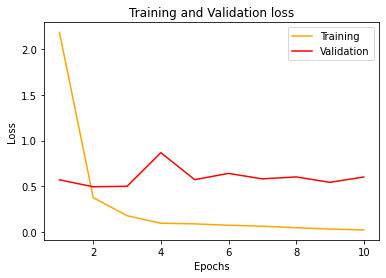

In [54]:
loss = model_1.history['loss']
val_loss = model_1.history['val_loss']
acc = model_1.history['accuracy']
val_acc = model_1.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 2 - Base CNN

* Building Model

In [55]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [56]:
model_complex = Sequential()
model_complex.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (224, 224, 3)))
model_complex.add(MaxPooling2D(pool_size = 2))
model_complex.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model_complex.add(MaxPooling2D(pool_size = 2))
model_complex.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model_complex.add(MaxPooling2D(pool_size = 2))
model_complex.add(Dropout(0.3))
model_complex.add(Flatten())
model_complex.add(Dense(units = 500, activation = 'relu'))
model_complex.add(Dropout(0.4)) #model_complex.add(Dropout(0.3))
model_complex.add(Dense(units = 2, activation = 'softmax')) #Check if the last Dense Layer(output) has same number of classes as the number of target classes in the training dataset.
model_complex.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 64)      

* Compiling Model

In [57]:
opt = optimizers.Adam(learning_rate=learning_Rate) 
model_complex.compile(optimizer=opt,
                    loss="categorical_crossentropy",
                    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

* Fitting Model

In [58]:
model_2 = model_complex.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs, #>=30 / Early stopping: 15 epochs
                    steps_per_epoch = steps_per_Epoch, 
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 56s 775ms/step - loss: 0.7455 - accuracy: 0.6615 - recall: 0.6615 - precision: 0.6615 - auc: 0.6769 - val_loss: 0.6056 - val_accuracy: 0.6806 - val_recall: 0.6806 - val_precision: 0.6806 - val_auc: 0.7277 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 54s 760ms/step - loss: 0.5683 - accuracy: 0.6948 - recall: 0.6948 - precision: 0.6948 - auc: 0.7718 - val_loss: 0.5568 - val_accuracy: 0.7120 - val_recall: 0.7120 - val_precision: 0.7120 - val_auc: 0.7899 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 53s 753ms/step - loss: 0.4551 - accuracy: 0.7752 - recall: 0.7752 - precision: 0.7752 - auc: 0.8674 - val_loss: 0.5517 - val_accuracy: 0.7173 - val_recall: 0.7173 - val_precision: 0.7173 - val_auc: 0.8026 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 54s 756ms/step - loss: 0.3096 - accuracy: 0.8738 - recall: 0.8738 - precision: 0.8738 - auc: 0.9445 - val_loss: 0.4736 - val_accuracy: 0.7

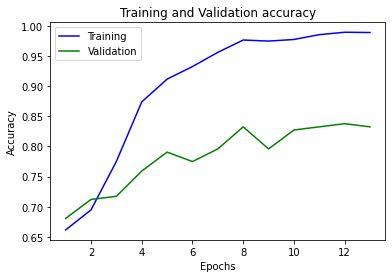

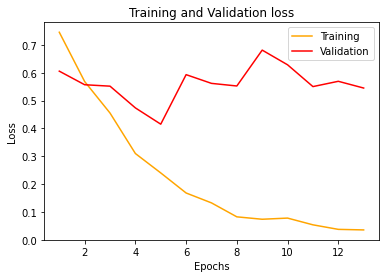

In [59]:
loss = model_2.history['loss']
val_loss = model_2.history['val_loss']
acc = model_2.history['accuracy']
val_acc = model_2.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 3 - Adjusted Base CNN

In [179]:
# placeholder for comments regarding differences with model 2

In [60]:
#Model CNN with RmsProp Optimizer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout

* Building Model

In [61]:
model_complex_adj=Sequential()
model_complex_adj.add(Conv2D(filters = 16, kernel_size = 3, padding='same', activation = 'relu', input_shape = (224, 224, 3)))
model_complex_adj.add(MaxPooling2D(pool_size = 2))
model_complex_adj.add(Conv2D(filters = 32, kernel_size=3,padding='same', activation='relu'))
model_complex_adj.add(MaxPooling2D(pool_size = 2))
model_complex_adj.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu'))
model_complex_adj.add(MaxPooling2D(pool_size = 2))
model_complex_adj.add(Conv2D(filters = 128, kernel_size = 3, padding='same', activation = 'relu'))
model_complex_adj.add(MaxPooling2D(pool_size = 2))
model_complex_adj.add(Flatten())
model_complex_adj.add(Dense(units = 500, activation = 'relu'))
model_complex_adj.add(Dropout(0.3))
model_complex_adj.add(Dense(units = 50, activation = 'relu'))
model_complex_adj.add(Dense(units = 2, activation ='softmax'))
model_complex_adj.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 28, 28, 64)      

* Compiling Model

In [62]:
model_complex_adj.compile(
    optimizer = "rmsprop",
    loss = "categorical_crossentropy",
    metrics = ['accuracy', 'Recall', 'Precision', 'AUC']
)

* Fitting Model

In [63]:
model_3 = model_complex_adj.fit(
                    x = X_train,
                    y = y_train,
                    steps_per_epoch = steps_per_Epoch,
                    epochs = num_Epochs,
                    batch_size = batch_Size,
                    verbose = 1, 
                    shuffle = True,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping, lrr]
                )

Epoch 1/50
71/71 [==============================] - 57s 787ms/step - loss: 0.7523 - accuracy: 0.6642 - recall: 0.6642 - precision: 0.6642 - auc: 0.6689 - val_loss: 0.6274 - val_accuracy: 0.6754 - val_recall: 0.6754 - val_precision: 0.6754 - val_auc: 0.7114 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 55s 785ms/step - loss: 0.6491 - accuracy: 0.6739 - recall: 0.6739 - precision: 0.6739 - auc: 0.6942 - val_loss: 0.6073 - val_accuracy: 0.6754 - val_recall: 0.6754 - val_precision: 0.6754 - val_auc: 0.7343 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 55s 774ms/step - loss: 0.6172 - accuracy: 0.6873 - recall: 0.6873 - precision: 0.6873 - auc: 0.7418 - val_loss: 0.6235 - val_accuracy: 0.6754 - val_recall: 0.6754 - val_precision: 0.6754 - val_auc: 0.7612 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 55s 776ms/step - loss: 0.5381 - accuracy: 0.7419 - recall: 0.7419 - precision: 0.7419 - auc: 0.8163 - val_loss: 0.5571 - val_accuracy: 0.7

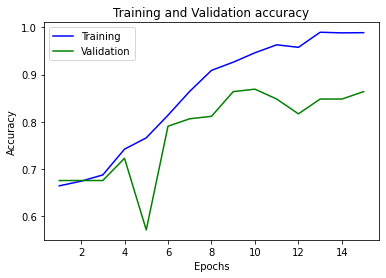

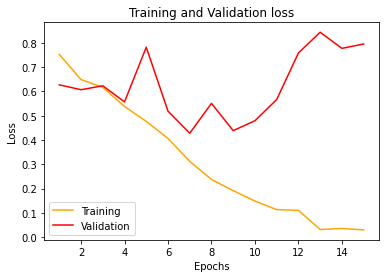

In [64]:
loss = model_3.history['loss']
val_loss = model_3.history['val_loss']
acc = model_3.history['accuracy']
val_acc = model_3.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 4 - InceptionV3

In [69]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
import tensorflow as tf
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

* Bulding Model

In [279]:
inceptv3 = InceptionV3(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top = False
)

for layer in inceptv3.layers:
    layer.trainable = False

inception_v3 = Sequential([
        inceptv3,
        GlobalAveragePooling2D(),
        Dense(2, activation='softmax')
    ])
inception_v3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


* Compiling Model

In [280]:
opt = optimizers.Adam(learning_rate=learning_Rate*10) 
inception_v3.compile(optimizer = opt,
                        loss = "categorical_crossentropy",
                        metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

* Fitting Model

In [281]:
model_4 = inception_v3.fit(
                    x = X_train,
                    y = y_train,
                    epochs = num_Epochs,
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size,
                    verbose = 1,
                    validation_data = (X_val,y_val),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 80s 887ms/step - loss: 1.0976 - accuracy: 0.6967 - recall: 0.6967 - precision: 0.6967 - auc: 0.7623 - val_loss: 0.4167 - val_accuracy: 0.7906 - val_recall: 0.7906 - val_precision: 0.7906 - val_auc: 0.8914 - lr: 0.0100
Epoch 2/50
71/71 [==============================] - 56s 802ms/step - loss: 0.5444 - accuracy: 0.7832 - recall: 0.7832 - precision: 0.7832 - auc: 0.8652 - val_loss: 0.7243 - val_accuracy: 0.7435 - val_recall: 0.7435 - val_precision: 0.7435 - val_auc: 0.8506 - lr: 0.0100
Epoch 3/50
71/71 [==============================] - 56s 783ms/step - loss: 0.5257 - accuracy: 0.7992 - recall: 0.7992 - precision: 0.7992 - auc: 0.8862 - val_loss: 0.6989 - val_accuracy: 0.7592 - val_recall: 0.7592 - val_precision: 0.7592 - val_auc: 0.8614 - lr: 0.0100
Epoch 4/50
71/71 [==============================] - 56s 794ms/step - loss: 0.4421 - accuracy: 0.8241 - recall: 0.8241 - precision: 0.8241 - auc: 0.9112 - val_loss: 0.4936 - val_accuracy: 0.7

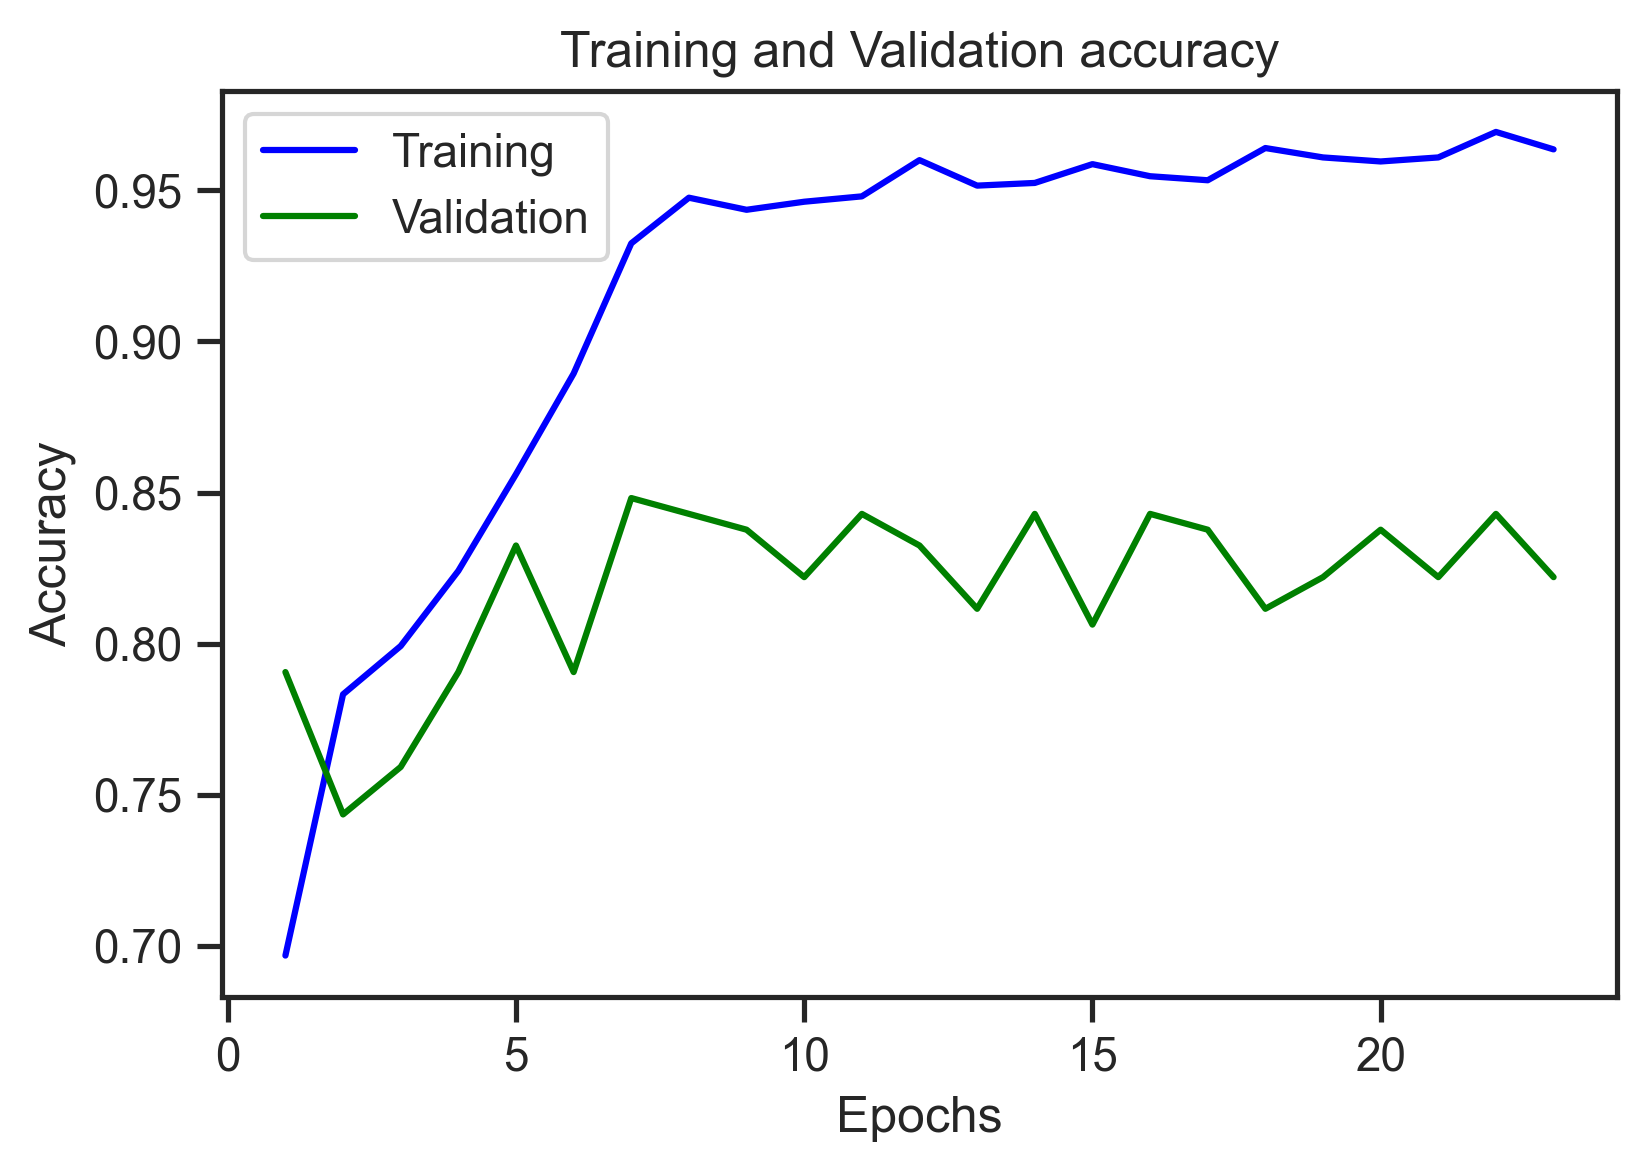

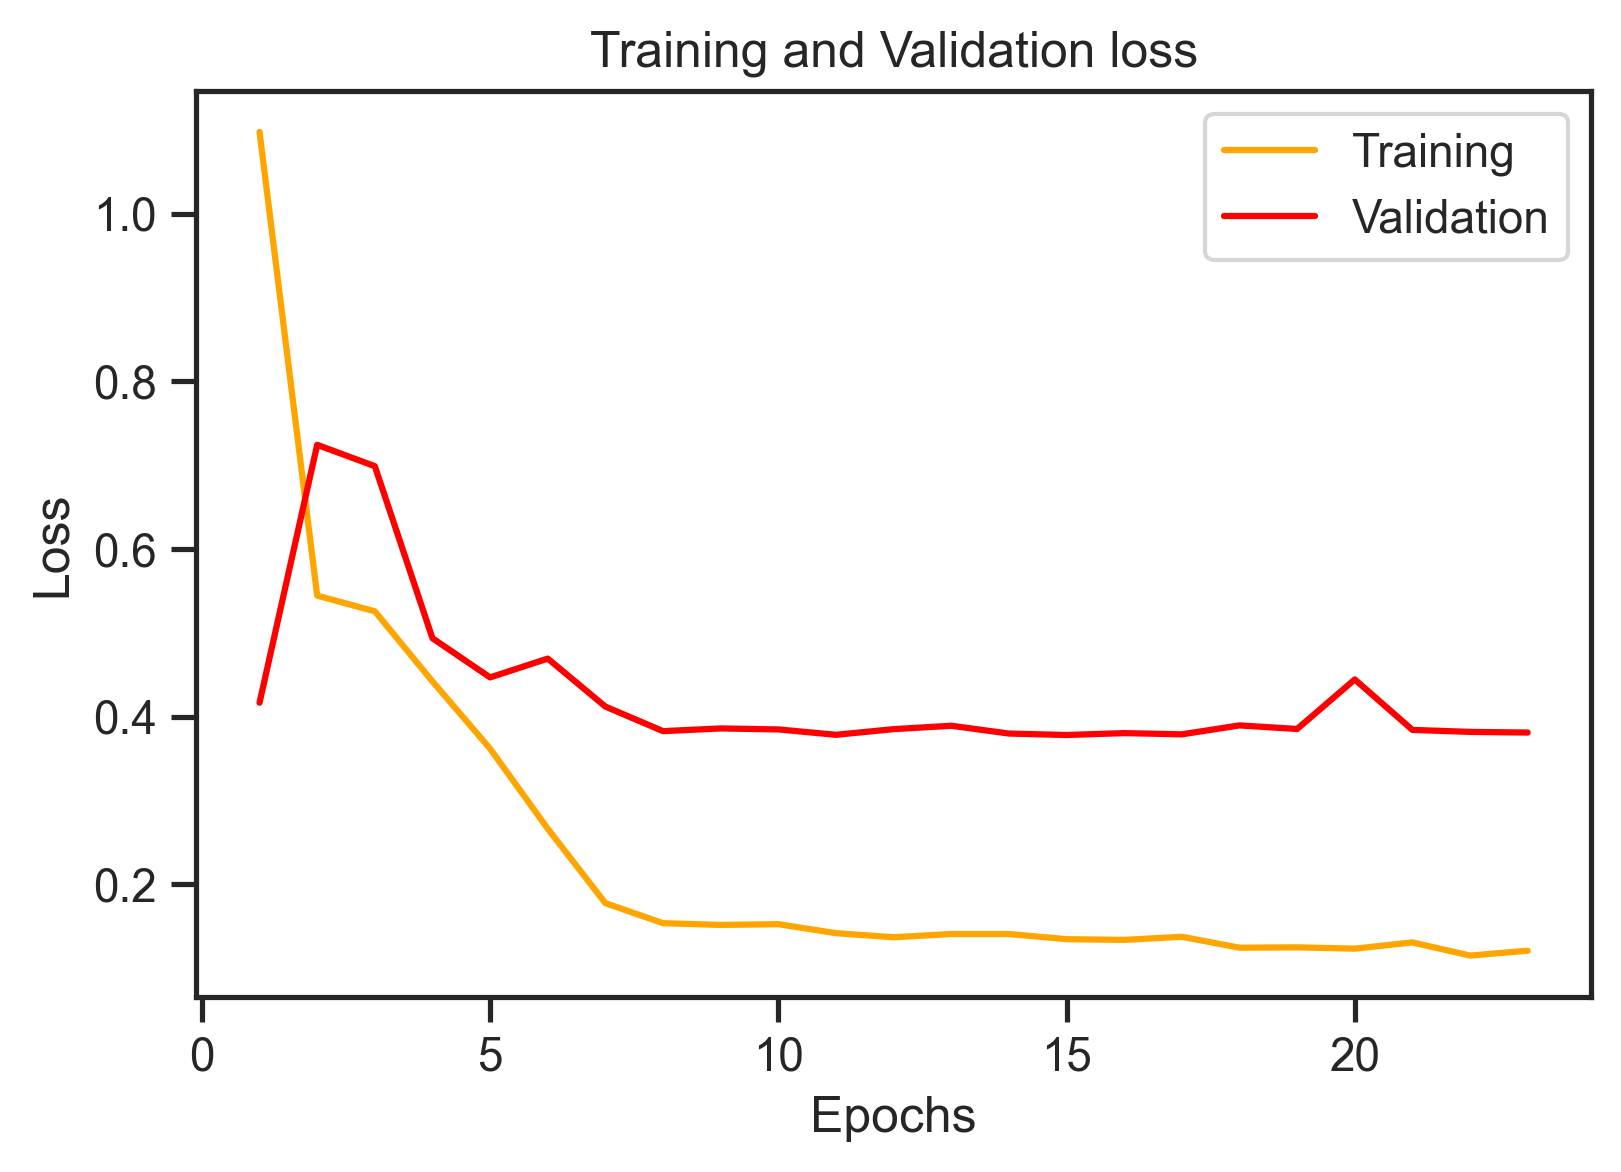

In [282]:
loss = model_4.history['loss']
val_loss = model_4.history['val_loss']
acc = model_4.history['accuracy']
val_acc = model_4.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model 5 - MobileNet2

* Building Model

In [84]:
# transform to appropriate MobileNet2 input / normalize to (-1, 1)
data_mn2 = tf.keras.applications.mobilenet_v2.preprocess_input(full_imgs_array)

In [85]:
# split into train test sets
X_train_mn, X_test_1_mn, y_train_mn, y_test_1_mn = train_test_split(data_mn2, full_imgs_labels,
                                                    stratify = full_imgs_labels, 
                                                    test_size = 0.25, random_state = 5)

X_test_mn, X_val_mn, y_test_mn, y_val_mn = train_test_split(X_test_1_mn, y_test_1_mn,
                                                    stratify = y_test_1_mn, 
                                                    test_size = 0.25, random_state = 5)

In [104]:
mob_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

x = mob_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) #dense layer 2
x = Dense(512, activation='relu')(x) #dense layer 3
preds = Dense(2, activation='softmax')(x) #final layer with softmax activation

In [105]:
mob_net2 = Model(inputs = mob_net.input, outputs = preds)

In [102]:
for i,layer in enumerate(mob_net2.layers):
  print(i,layer.name)

0 input_3
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [106]:
for layer in mob_net2.layers[:152]:
    layer.trainable=False

mob_net2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

* Compiling Model

In [107]:
opt = optimizers.Adam(learning_rate=learning_Rate*10) 
mob_net2.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics = ['accuracy', 'Recall', 'Precision', 'AUC'])

* Fitting Model

In [108]:
model_5 = mob_net2.fit(
                    x = X_train_mn,
                    y = y_train_mn,
                    epochs = num_Epochs,
                    steps_per_epoch = steps_per_Epoch,
                    batch_size = batch_Size, 
                    verbose = 1,
                    validation_data = (X_val_mn, y_val_mn),
                    callbacks = [early_stopping, lrr]
                    )

Epoch 1/50
71/71 [==============================] - 55s 716ms/step - loss: 1.8948 - accuracy: 0.6910 - recall: 0.6910 - precision: 0.6910 - auc: 0.7503 - val_loss: 0.5459 - val_accuracy: 0.7120 - val_recall: 0.7120 - val_precision: 0.7120 - val_auc: 0.7964 - lr: 0.0100
Epoch 2/50
71/71 [==============================] - 49s 698ms/step - loss: 0.3979 - accuracy: 0.8108 - recall: 0.8108 - precision: 0.8108 - auc: 0.8989 - val_loss: 0.4781 - val_accuracy: 0.8010 - val_recall: 0.8010 - val_precision: 0.8010 - val_auc: 0.8606 - lr: 0.0100
Epoch 3/50
71/71 [==============================] - 49s 693ms/step - loss: 0.3408 - accuracy: 0.8467 - recall: 0.8467 - precision: 0.8467 - auc: 0.9271 - val_loss: 0.3762 - val_accuracy: 0.8220 - val_recall: 0.8220 - val_precision: 0.8220 - val_auc: 0.9132 - lr: 0.0100
Epoch 4/50
71/71 [==============================] - 49s 689ms/step - loss: 0.2738 - accuracy: 0.8769 - recall: 0.8769 - precision: 0.8769 - auc: 0.9535 - val_loss: 0.4827 - val_accuracy: 0.8

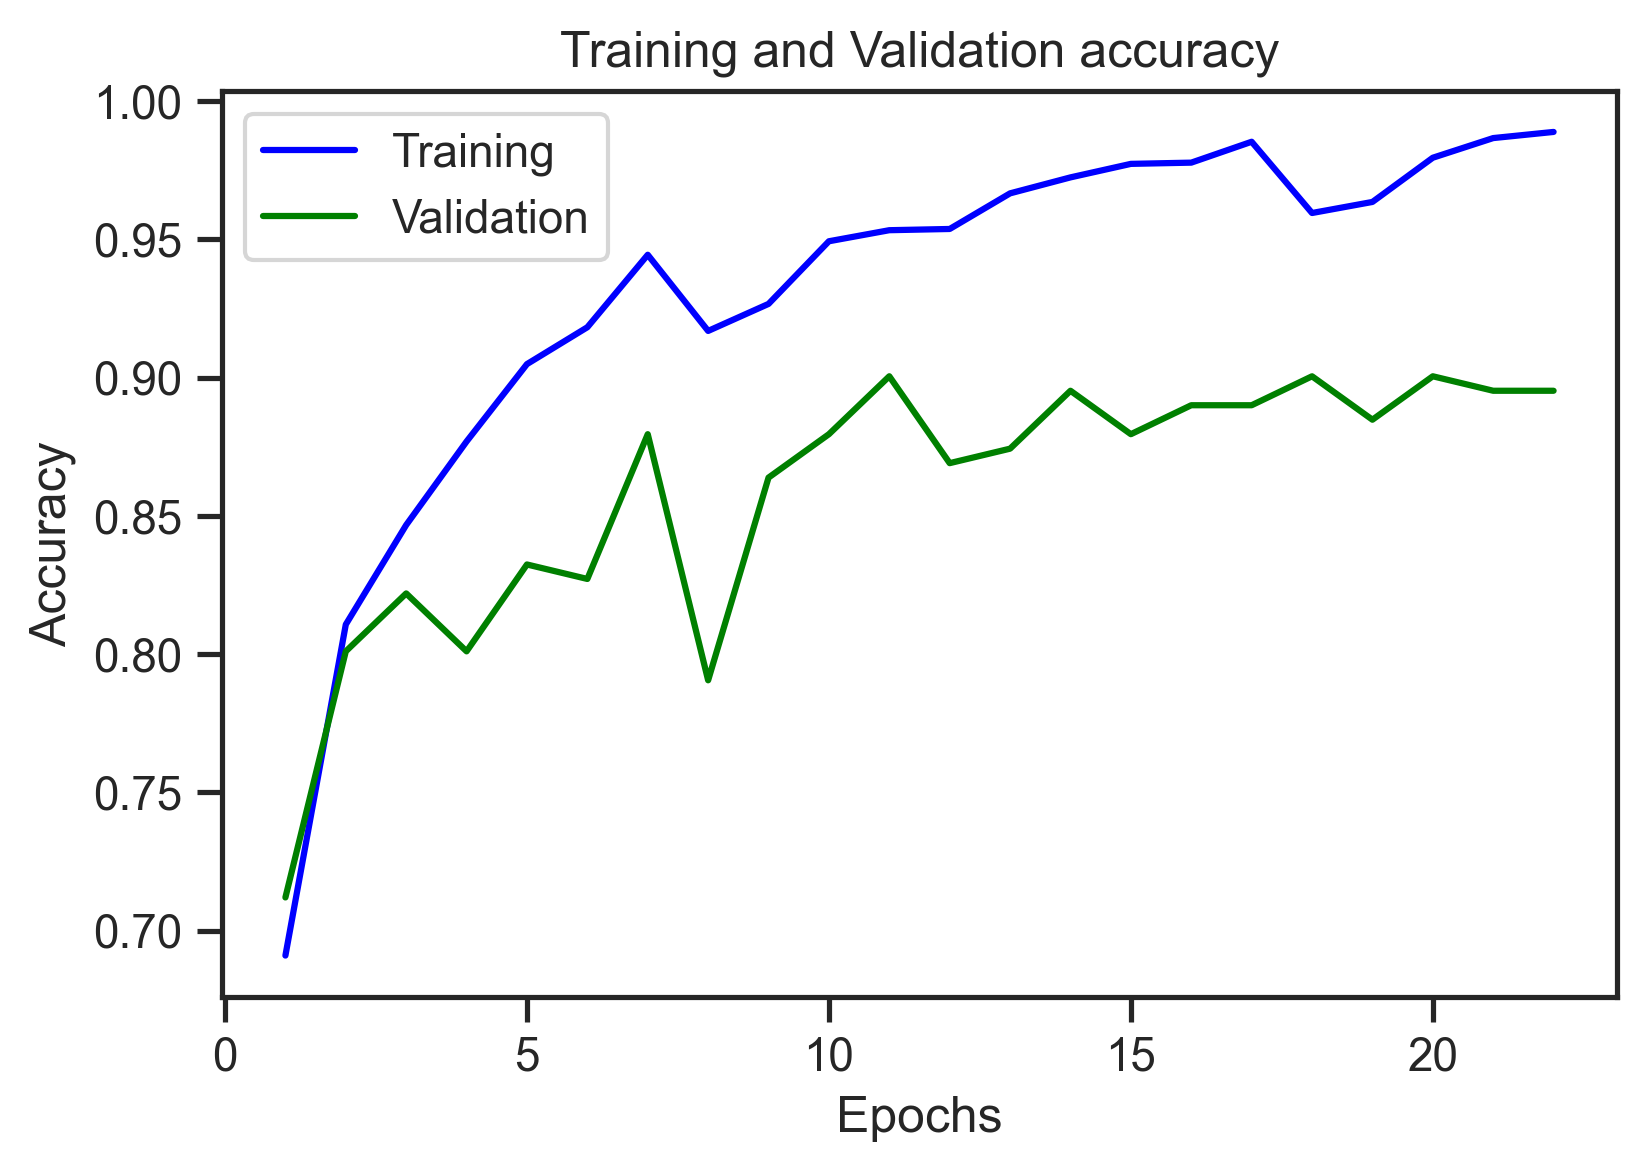

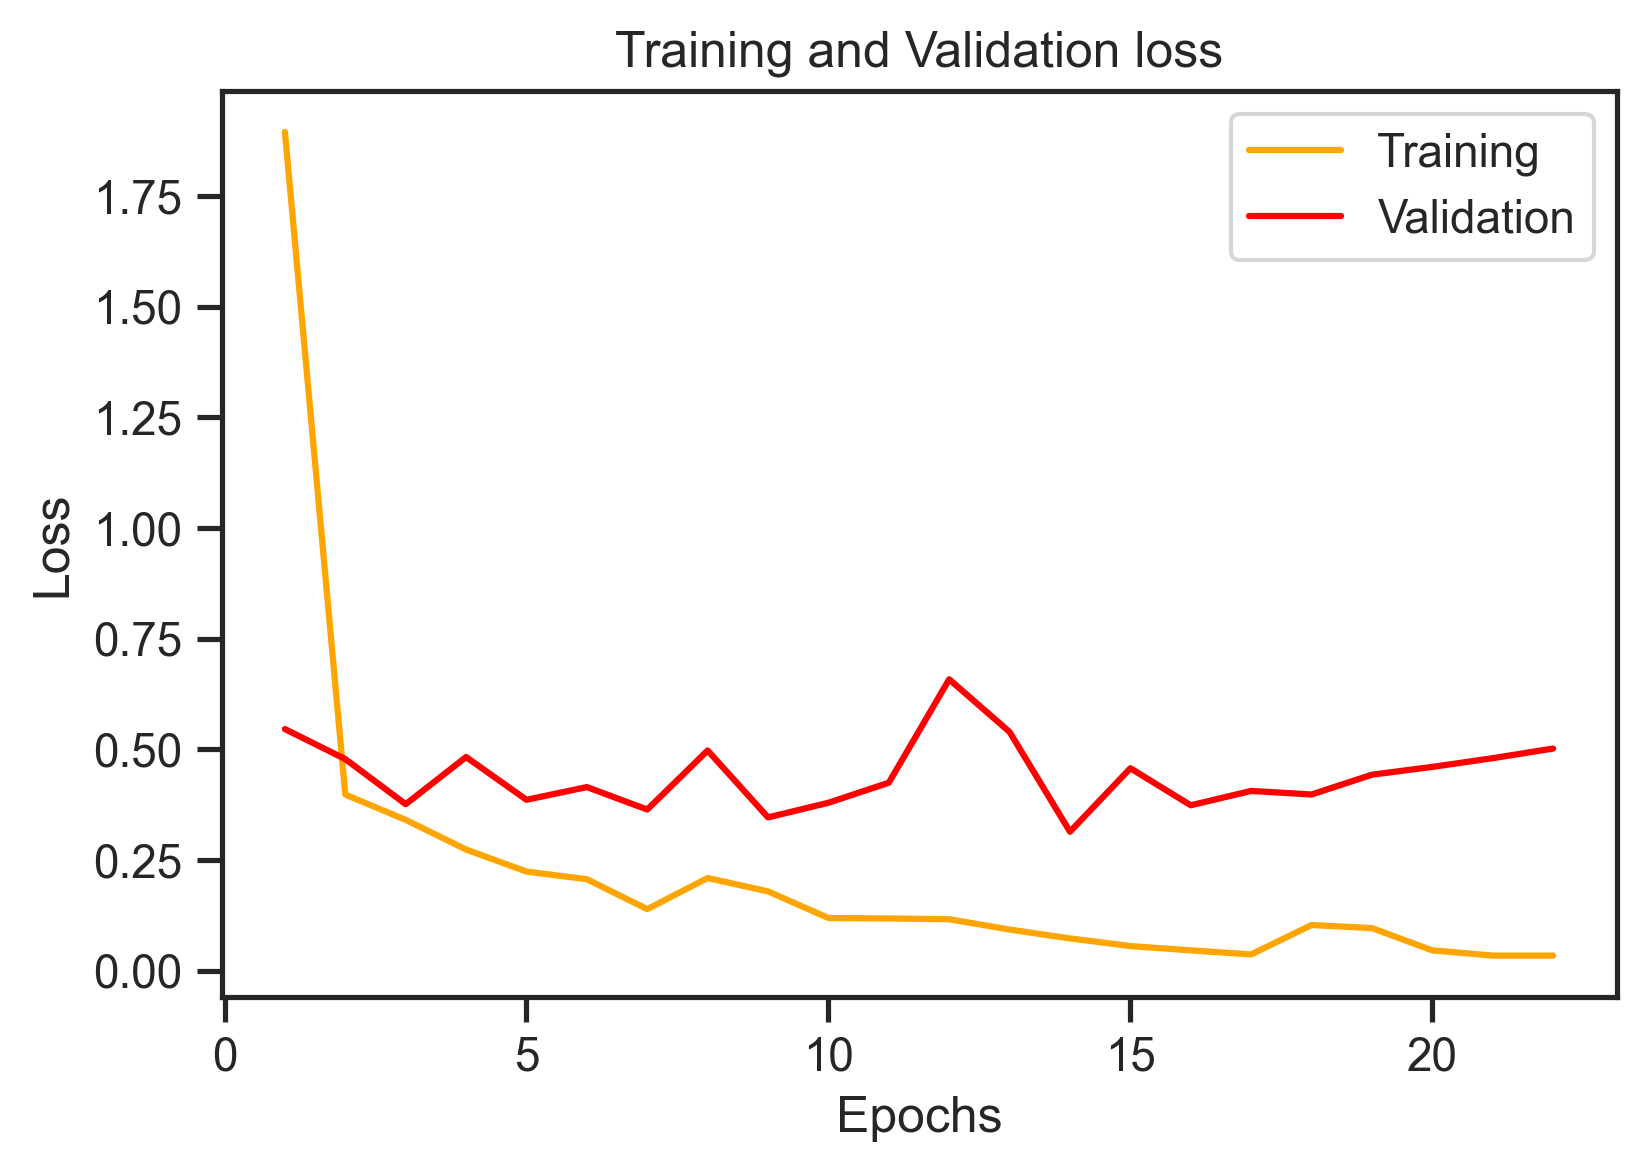

In [109]:
loss = model_5.history['loss']
val_loss = model_5.history['val_loss']
acc = model_5.history['accuracy']
val_acc = model_5.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# plotting accuracy 
plt.plot(epochs, acc, color='blue', label='Training')
plt.plot(epochs, val_acc, color='green', label='Validation')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plotting loss
plt.plot(epochs, loss, color='orange', label='Training')
plt.plot(epochs, val_loss, color='red', label='Validation')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Saving best model's weights

In [166]:
best_model = mob_net2
best_model.save_weights(r'.\team_quebec_results\best_model_weights')

## Models Comparison 


### Functions for plot loss and accuracy and evaluation

In [260]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
#     precision = precision_score(y, y_hat)
#     recall = recall_score(y, y_hat)
#     accuracy = accuracy_score(y,y_hat)
#     f1 = f1_score(y,y_hat)
#     report = classification_report(y,y_hat)
#     print(report)
#     print('Recall: ', recall)
#     print('Accuracy: ', accuracy)
#     print('Precision: ', precision)
#     print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

In [ ]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

### Compare classifiers

In [75]:
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss
from sklearn.datasets import make_classification
from sklearn import model_selection

In [131]:
# * Precision: The model precision score measures the proportion of positively predicted labels that are actually correct. Precision is also known as the positive predictive value. Precision Score = TP / (FP + TP)
# * Accuracy: Tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made predictions.  Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)
# * Recall score is used to measure the model performance in terms of measuring the count of true positives in a correct manner out of all the actual positive values.
# * F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively. 
#   F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)

In [283]:
classifiers = [model_few_Layers,
    model_complex,
    model_complex_adj,
    inception_v3,
    mob_net2
    ]
name_of_model = ["model_few_Layers",
    "model_complex",
    "model_complex_adj",
    "inception_v3",
    "mob_net2"
    ]

In [284]:
# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy", "Precision", "Recall", "F1", "AUC"]

log = pd.DataFrame(columns=log_cols)
i = 0

for clf in classifiers:

    name=name_of_model[i]
    i+=1    

    # if statamenet to use rescaled (-1, 1) test dataset for MobileNet2
    if name == name_of_model[-1]:
        y_true = np.argmax(y_test_mn, axis = 1)[:]
        pred = clf.predict(X_test_mn, verbose = 0) # Predict prob and get Class Indices
        y_pred= np.argmax(pred, axis = 1)[:]
    else:
        # calculate y_pred
        y_true = np.argmax(y_test, axis = 1)[:]
        pred = clf.predict(X_test, verbose = 0) # Predict prob and get Class Indices
        y_pred= np.argmax(pred, axis = 1)[:]

    # calculate accuracy
    acc = accuracy_score(y_pred[:], y_true[:])
    
    # calculate precision	
    pre = precision_score(y_pred[:], y_true[:])

    # calculate Recall	
    rec = recall_score(y_pred[:], y_true[:])

    # calculate F1-score
    f1 = f1_score(y_pred[:], y_true[:])

    # calculate scores
    auc = roc_auc_score(y_true, y_pred)
    
    # entry them in a dataframe for visualization
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100, f1*100, auc*100]], columns=log_cols)
    log = pd.concat([log, log_entry], axis = 0)
    
    # Print the results
    # print("="*30)   
    # print('**** Results ' + name + '****')
    # print("Accuracy: {:.4%}".format(acc))
    # print("Precision: {:.4%}".format(pre) )
    # print("Recall: {:.4%}".format(rec) )
    # print("F1-score: {:.4%}".format(f1) )
    # print( name + ": ROC AUC: {:.4%}".format(auc))

# print("="*15 + " End " + "="*15)

In [285]:
round(log.set_index('Classifier').sort_values(by='Accuracy', ascending = False), 1)

,Accuracy,Precision,Recall,F1,AUC
Classifier,,,,,
mob_net2,87.7,90.6,91.1,90.9,86.2
inception_v3,84.2,93.0,85.0,88.8,79.5
model_complex,82.3,91.1,83.9,87.4,77.6
model_complex_adj,81.2,93.5,81.4,87.0,74.7
model_few_Layers,78.1,88.3,80.9,84.4,72.6


### Evaluation Plots

In [113]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

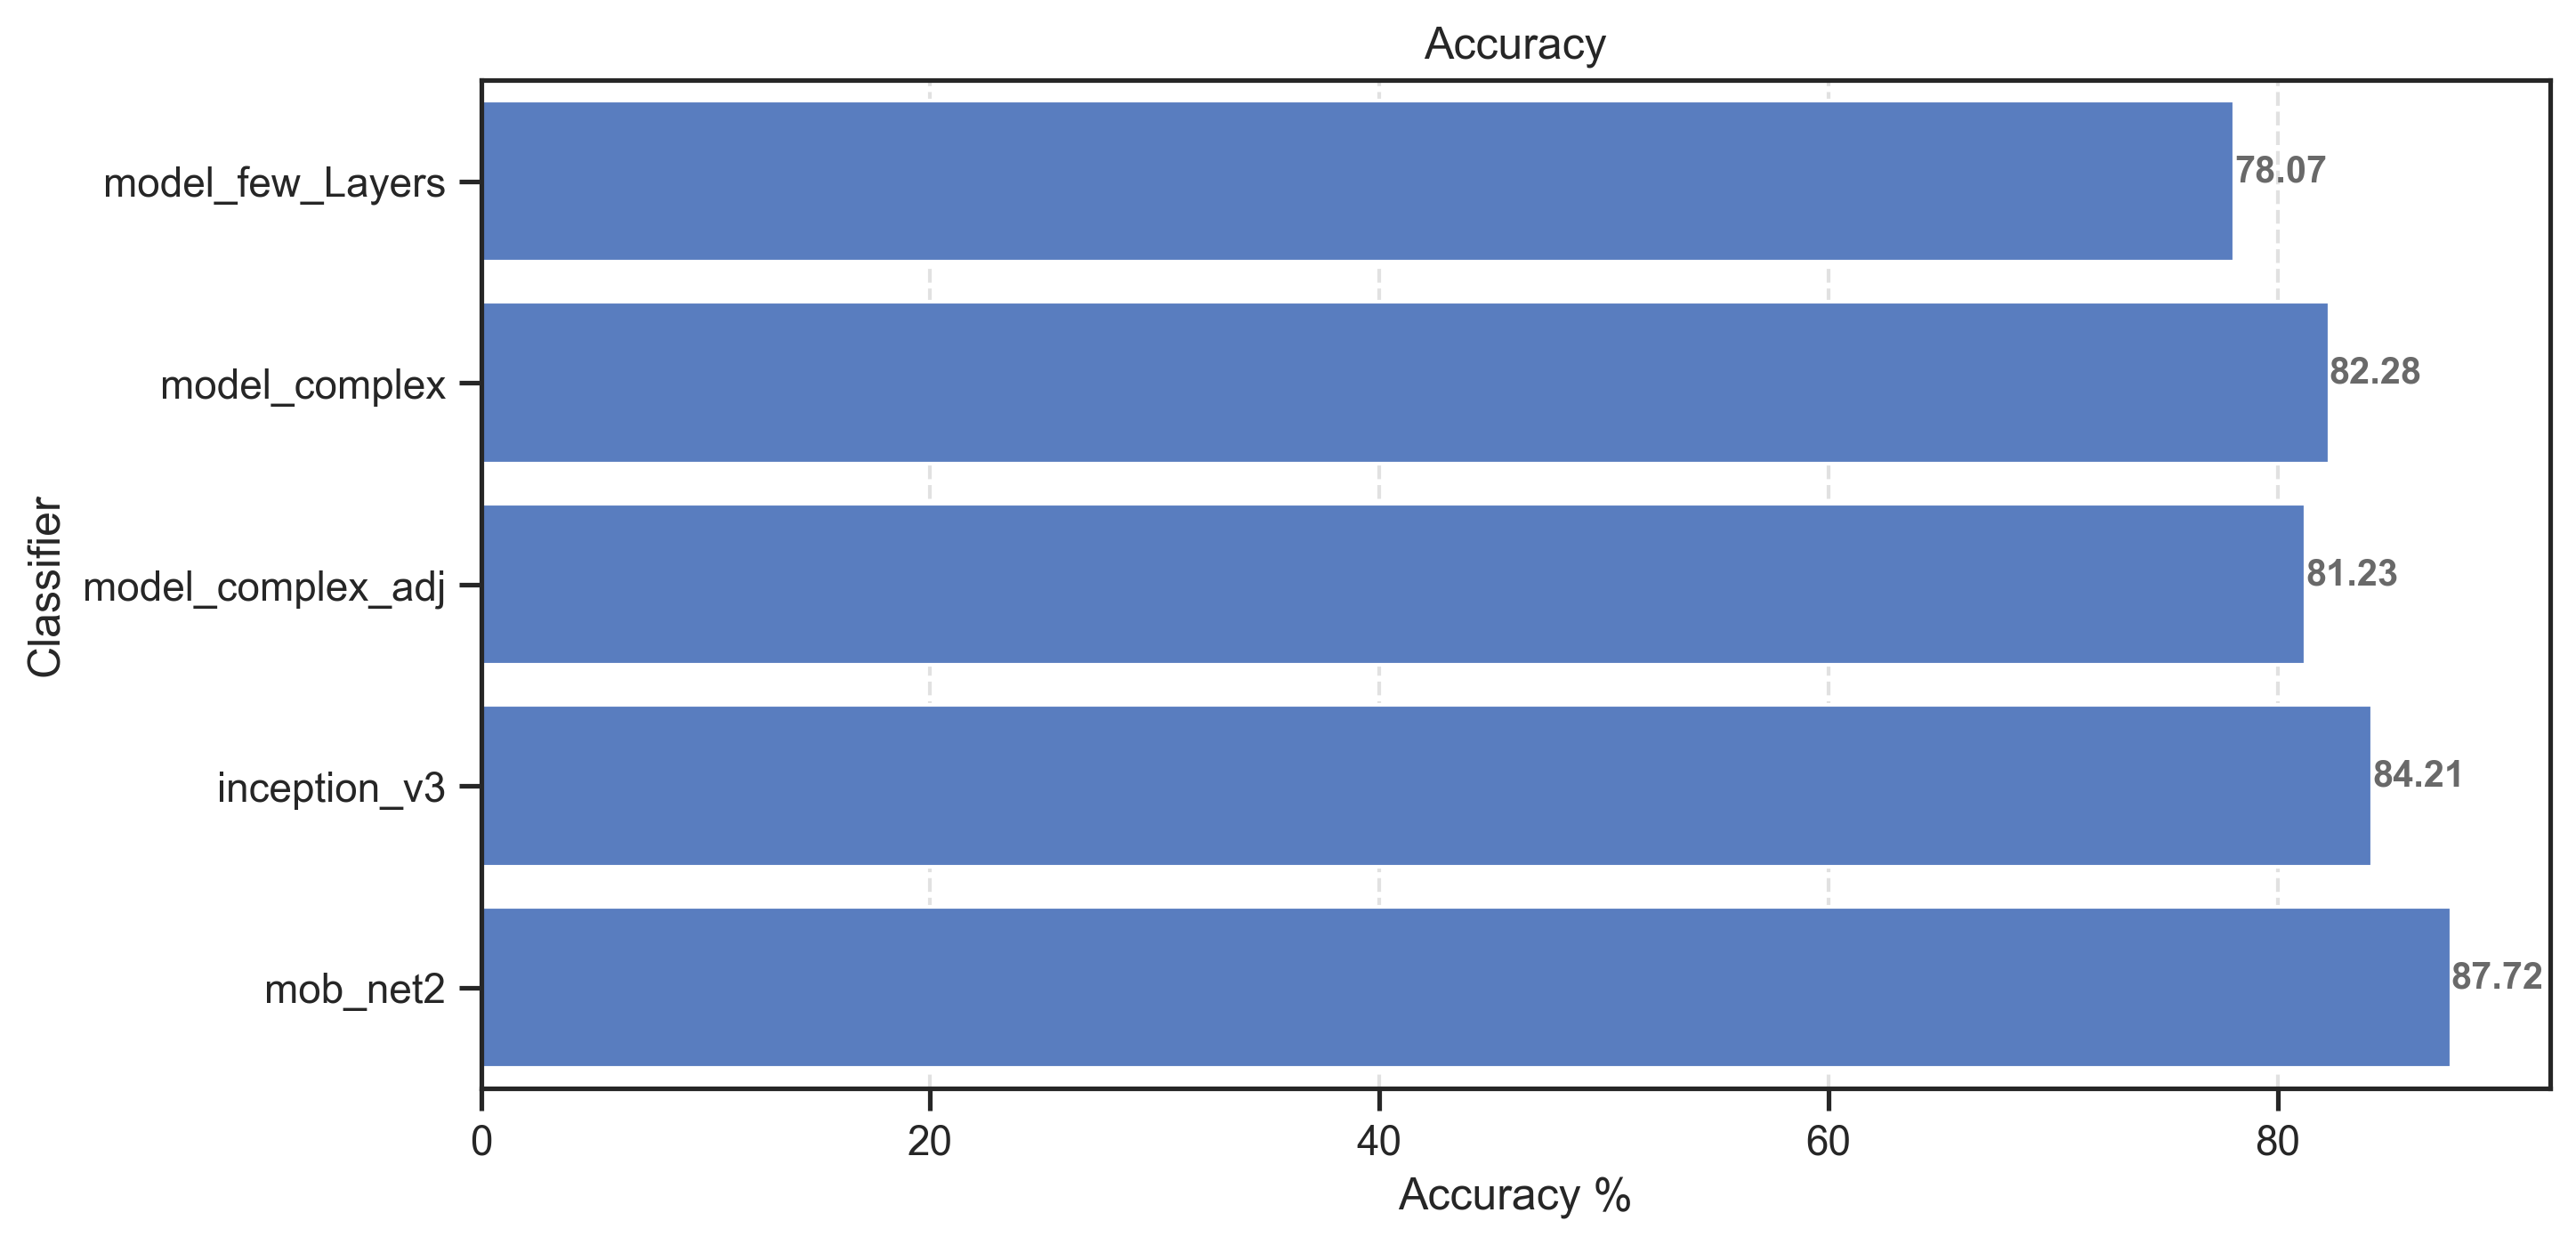

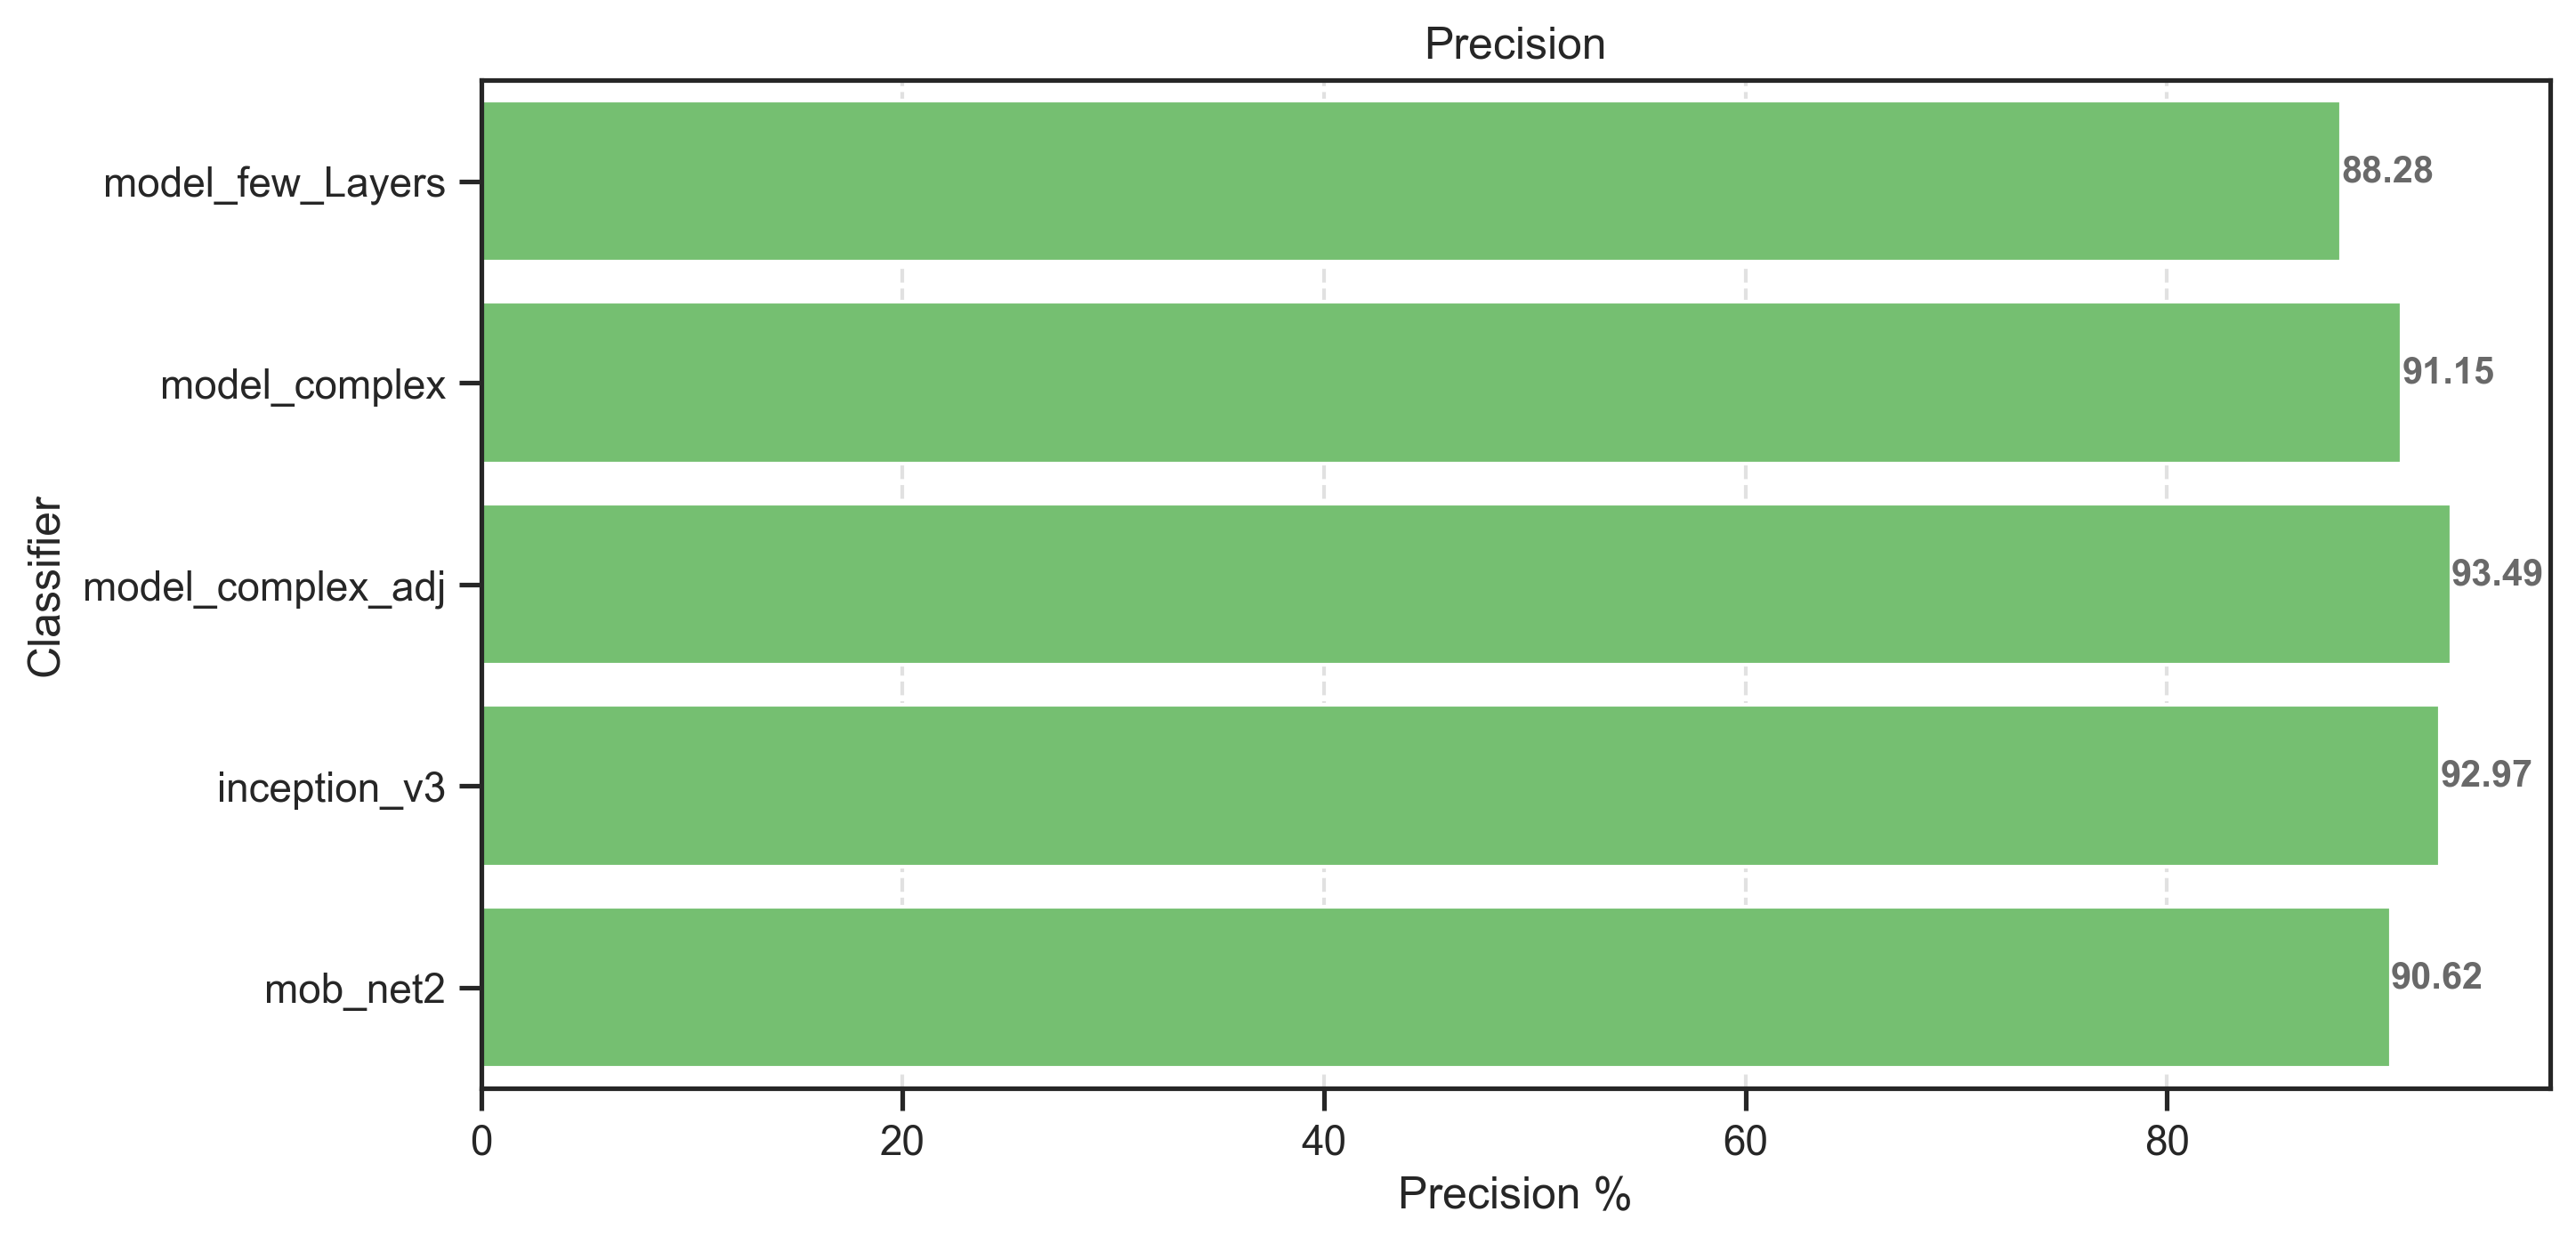

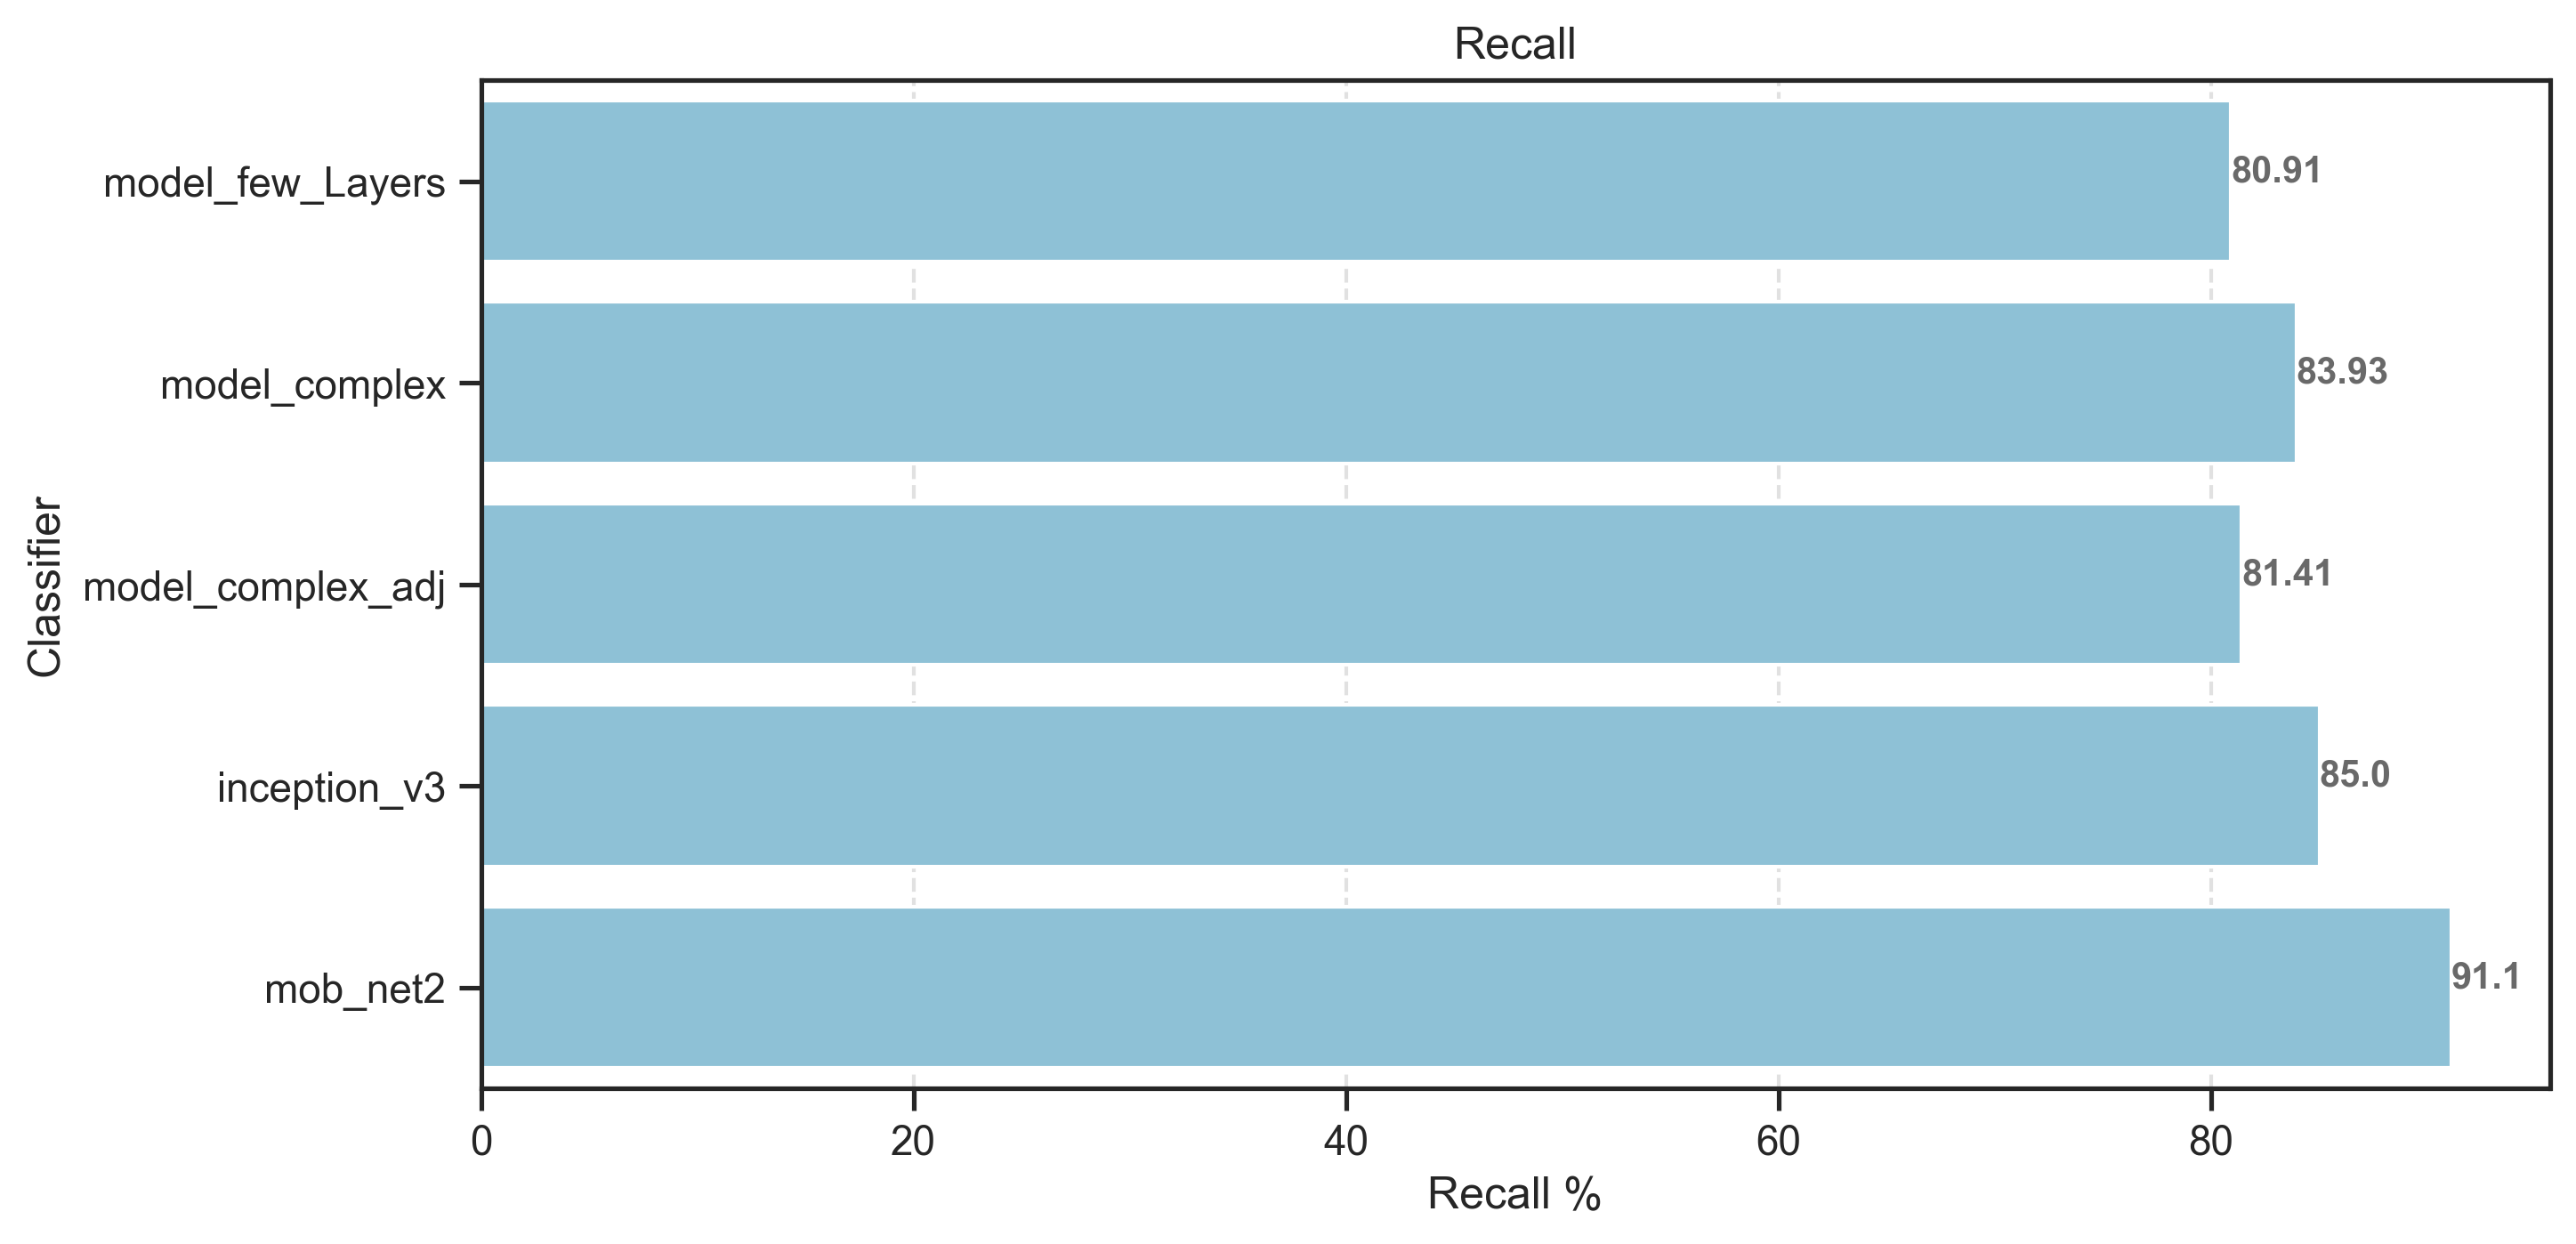

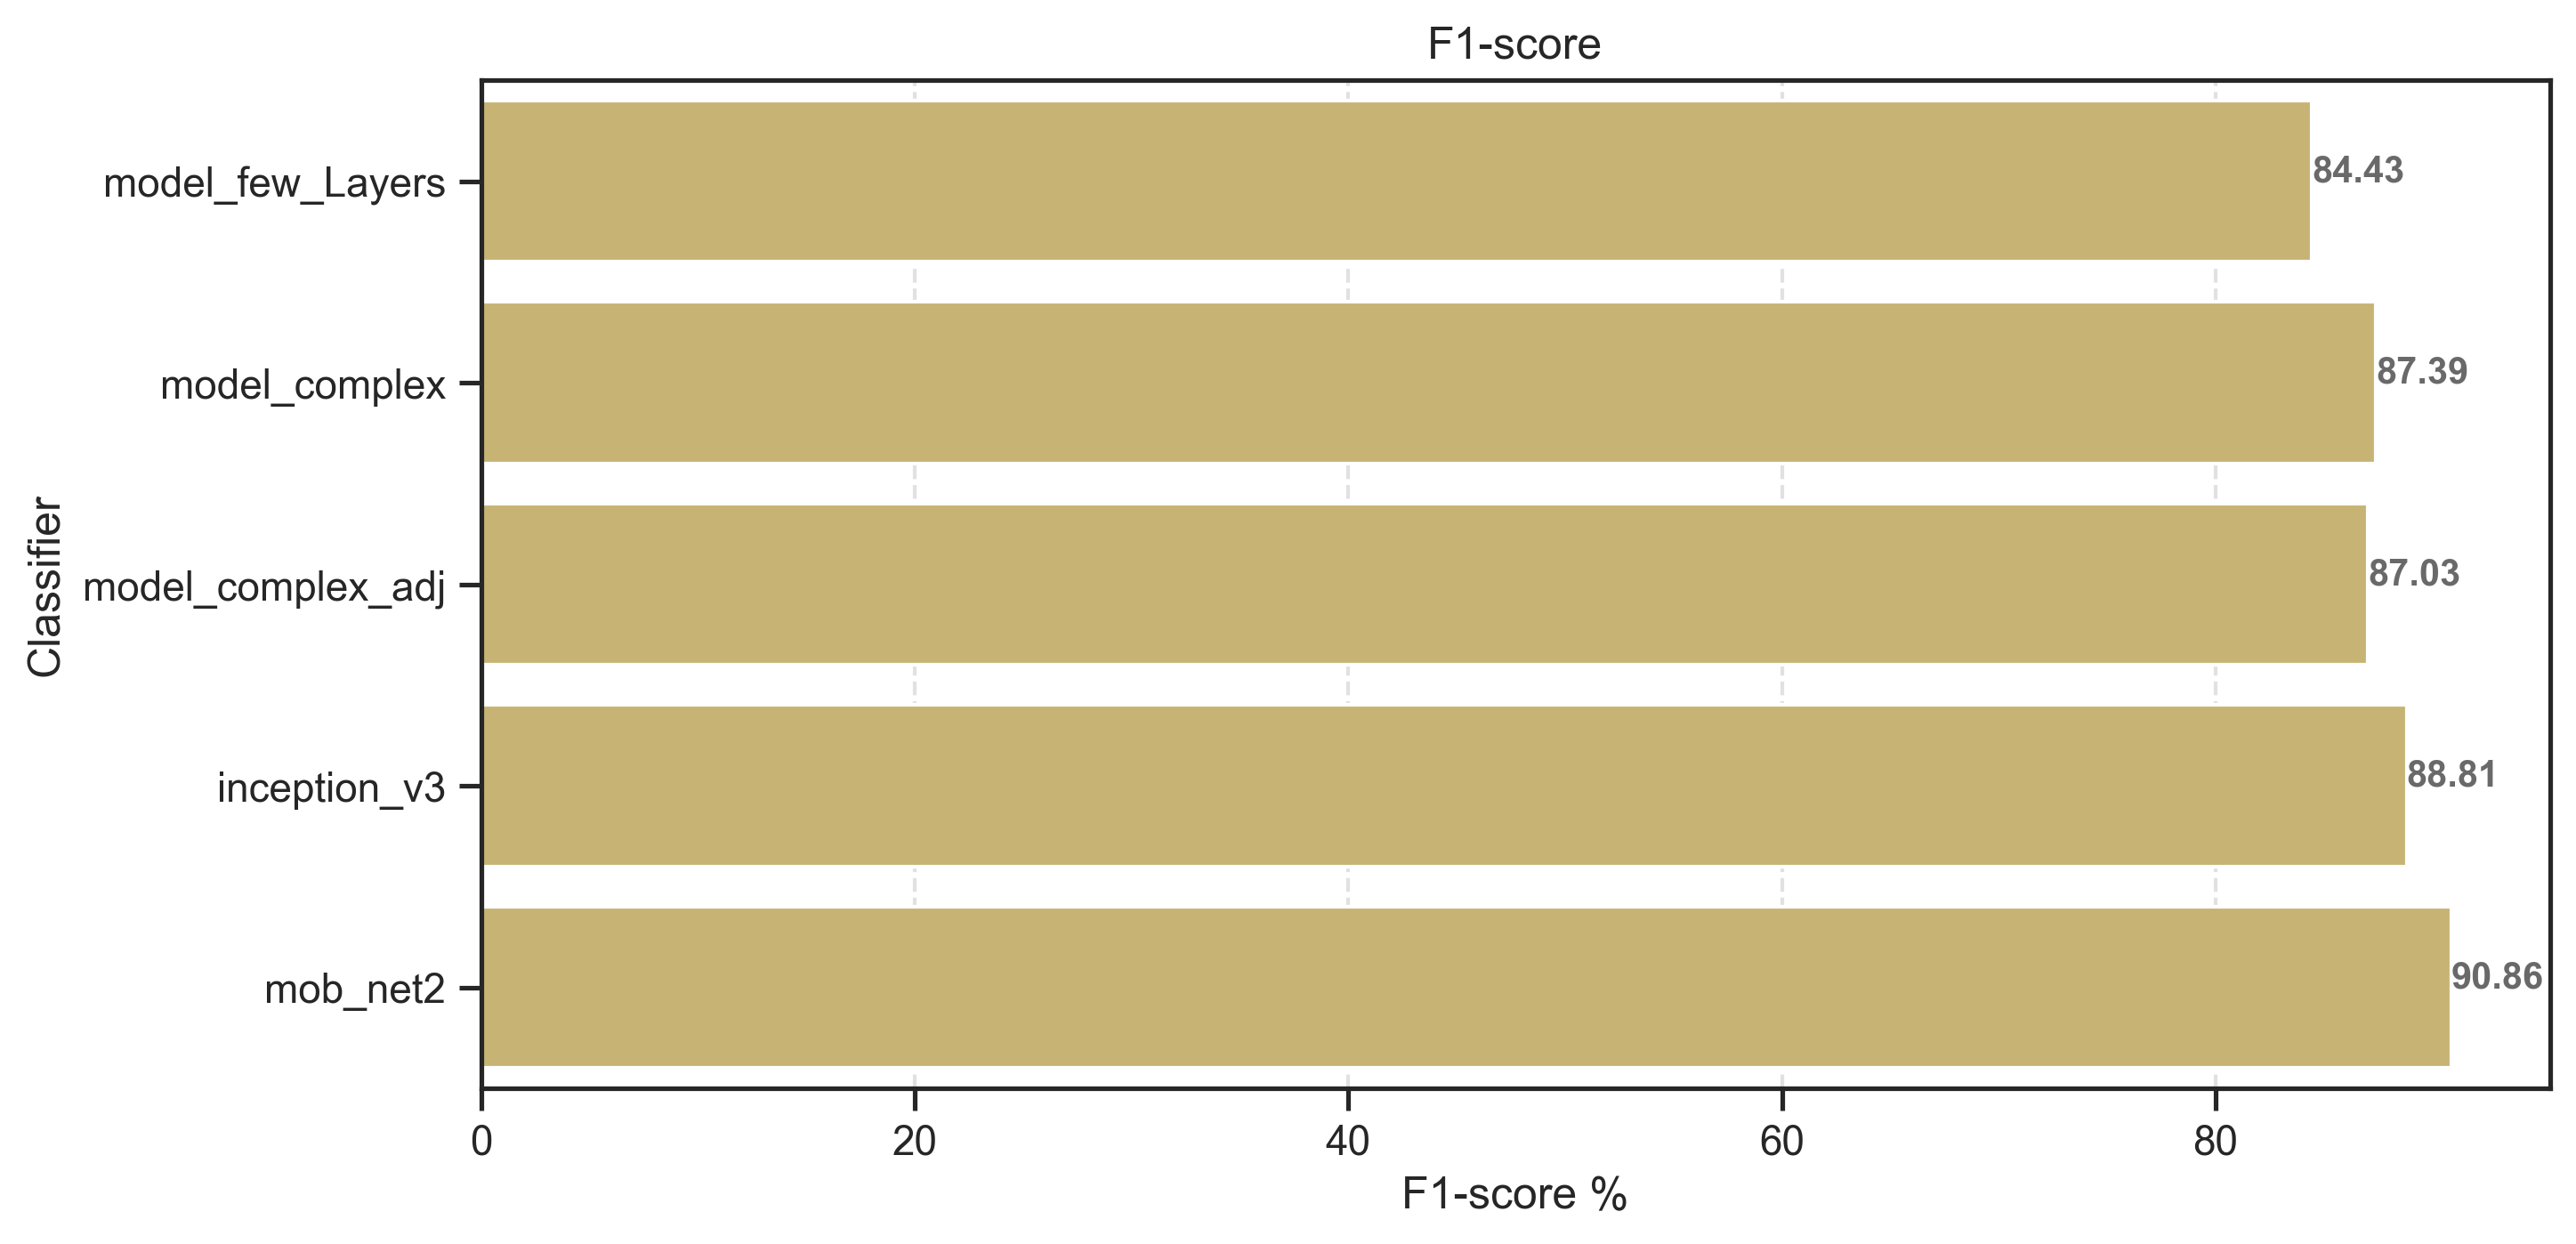

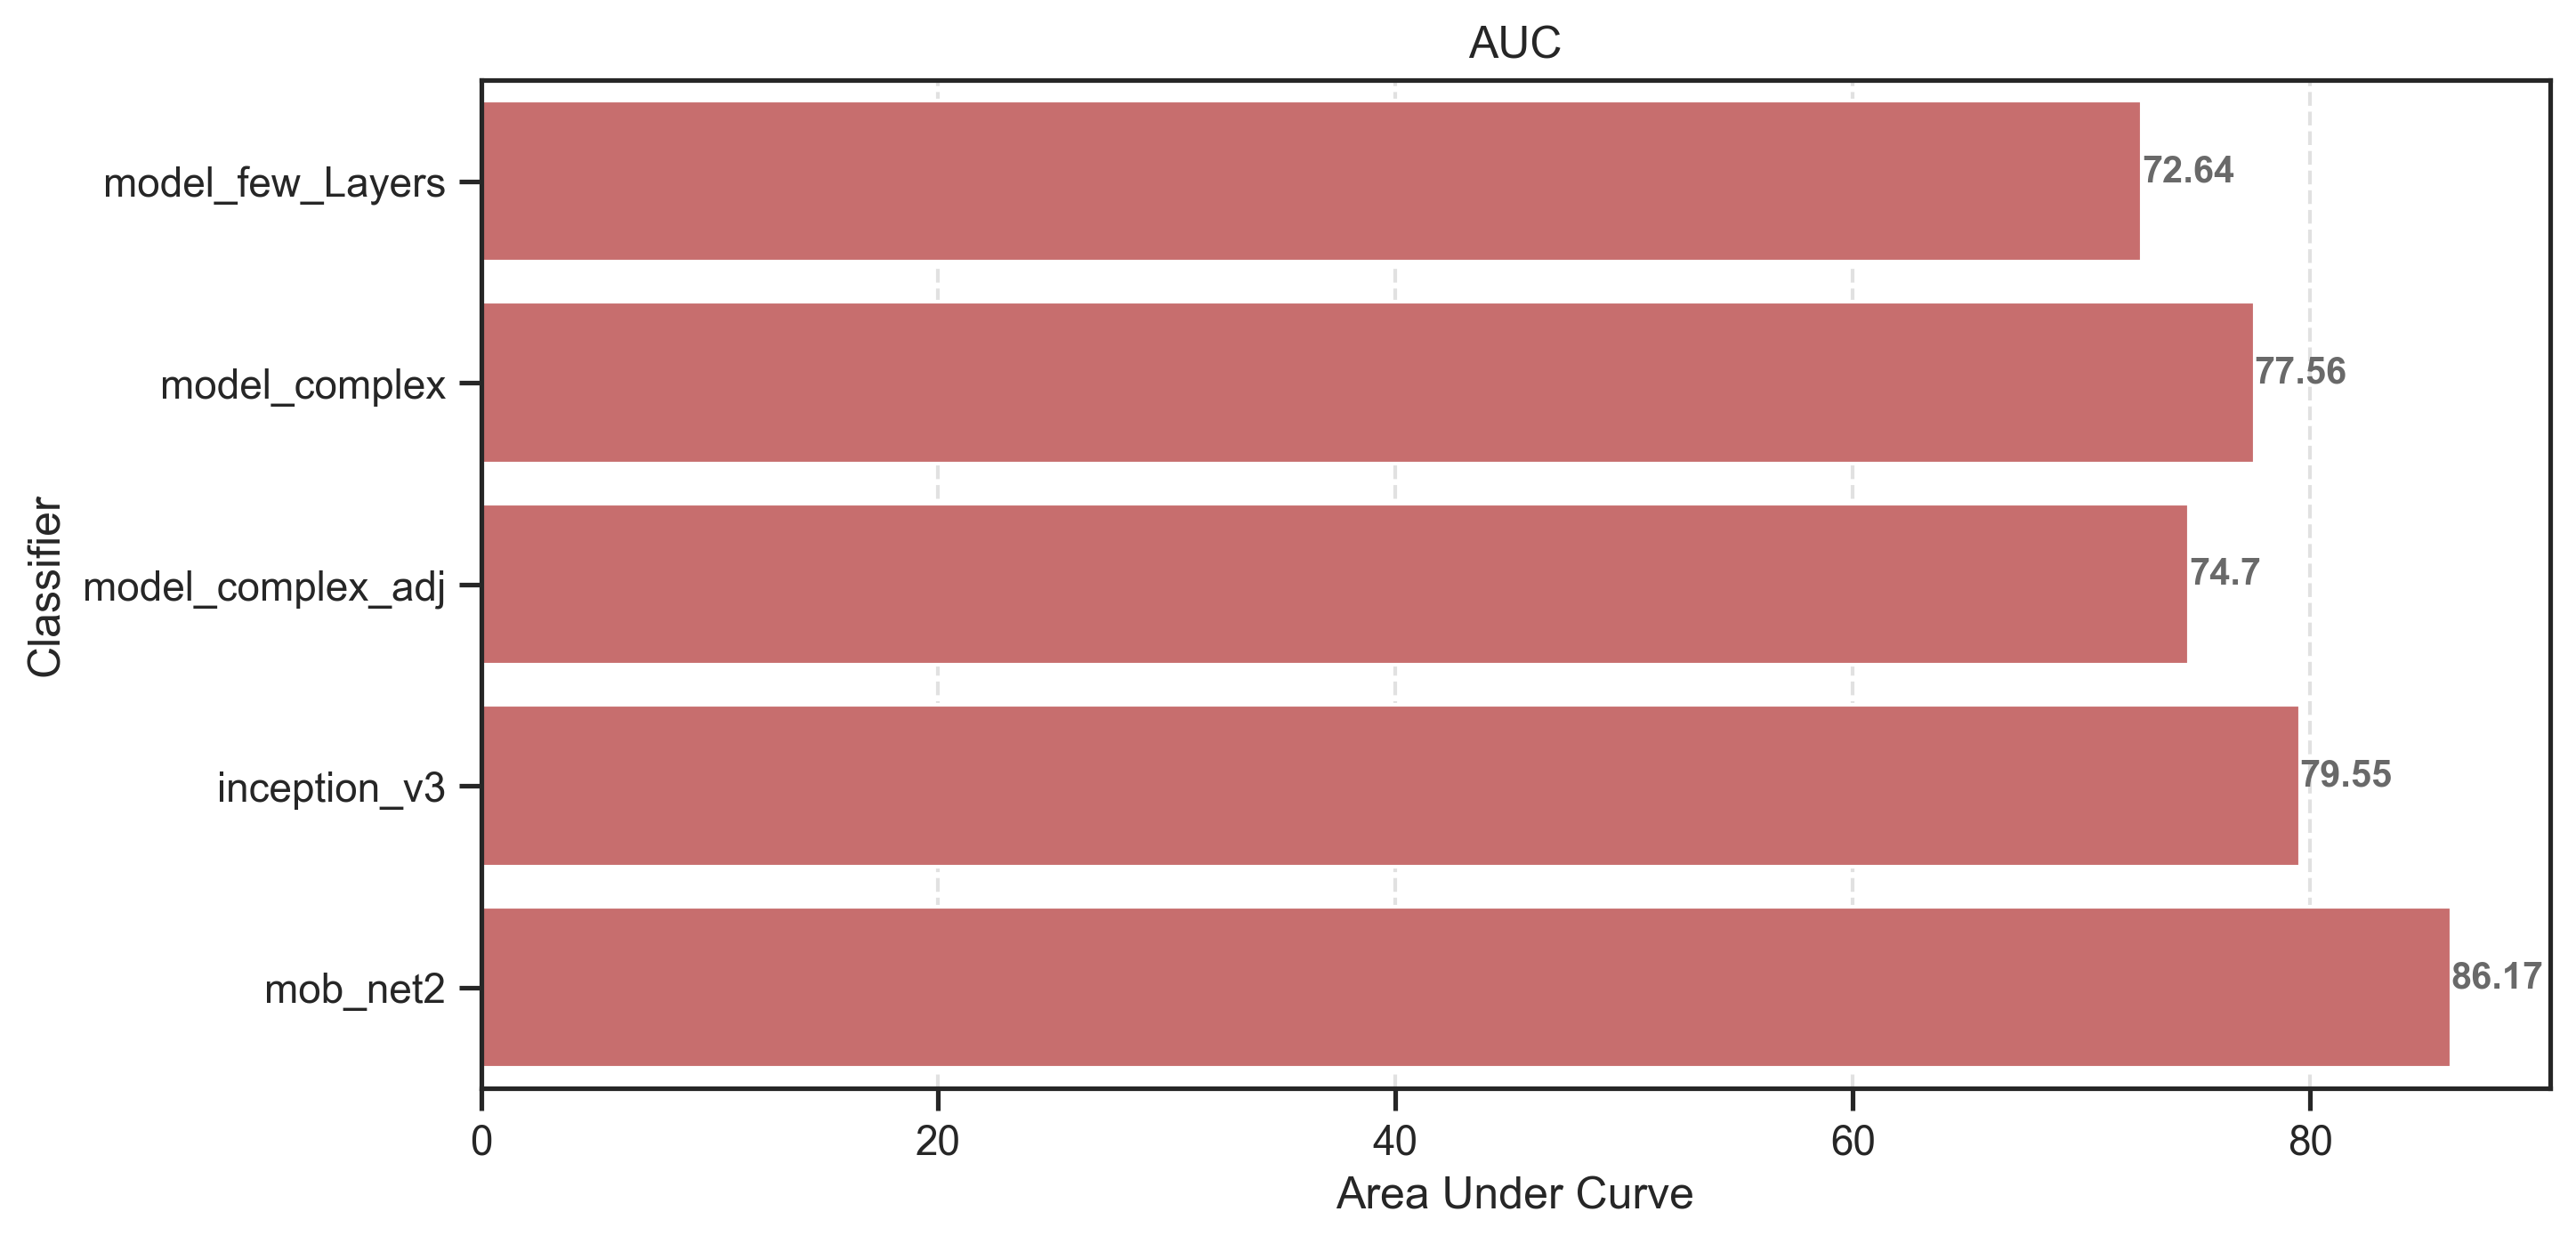

In [286]:
## Accuracy
# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Accuracy %')
plt.title('Accuracy')
plt.show()

## Precision

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log, color="g")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Precision %')
plt.title('Precision')
plt.show()

## Recall

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log, color='c')

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Recall %')
plt.title('Recall')
plt.show()

## F1

# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='F1', y='Classifier', data=log, color="y")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('F1-score %')
plt.title('F1-score')
plt.show()

## AUC
# Figure Size
fig, ax = plt.subplots(figsize =(10, 5))

# Add x, y gridlines
ax.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 1,
        alpha = 0.2)

sns.set_color_codes("muted")
sns.barplot(x='AUC', y='Classifier', data=log, color="r")

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width(), i.get_y()+0.4,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='dimgrey')

plt.xlabel('Area Under Curve')
plt.title('AUC')
plt.show()

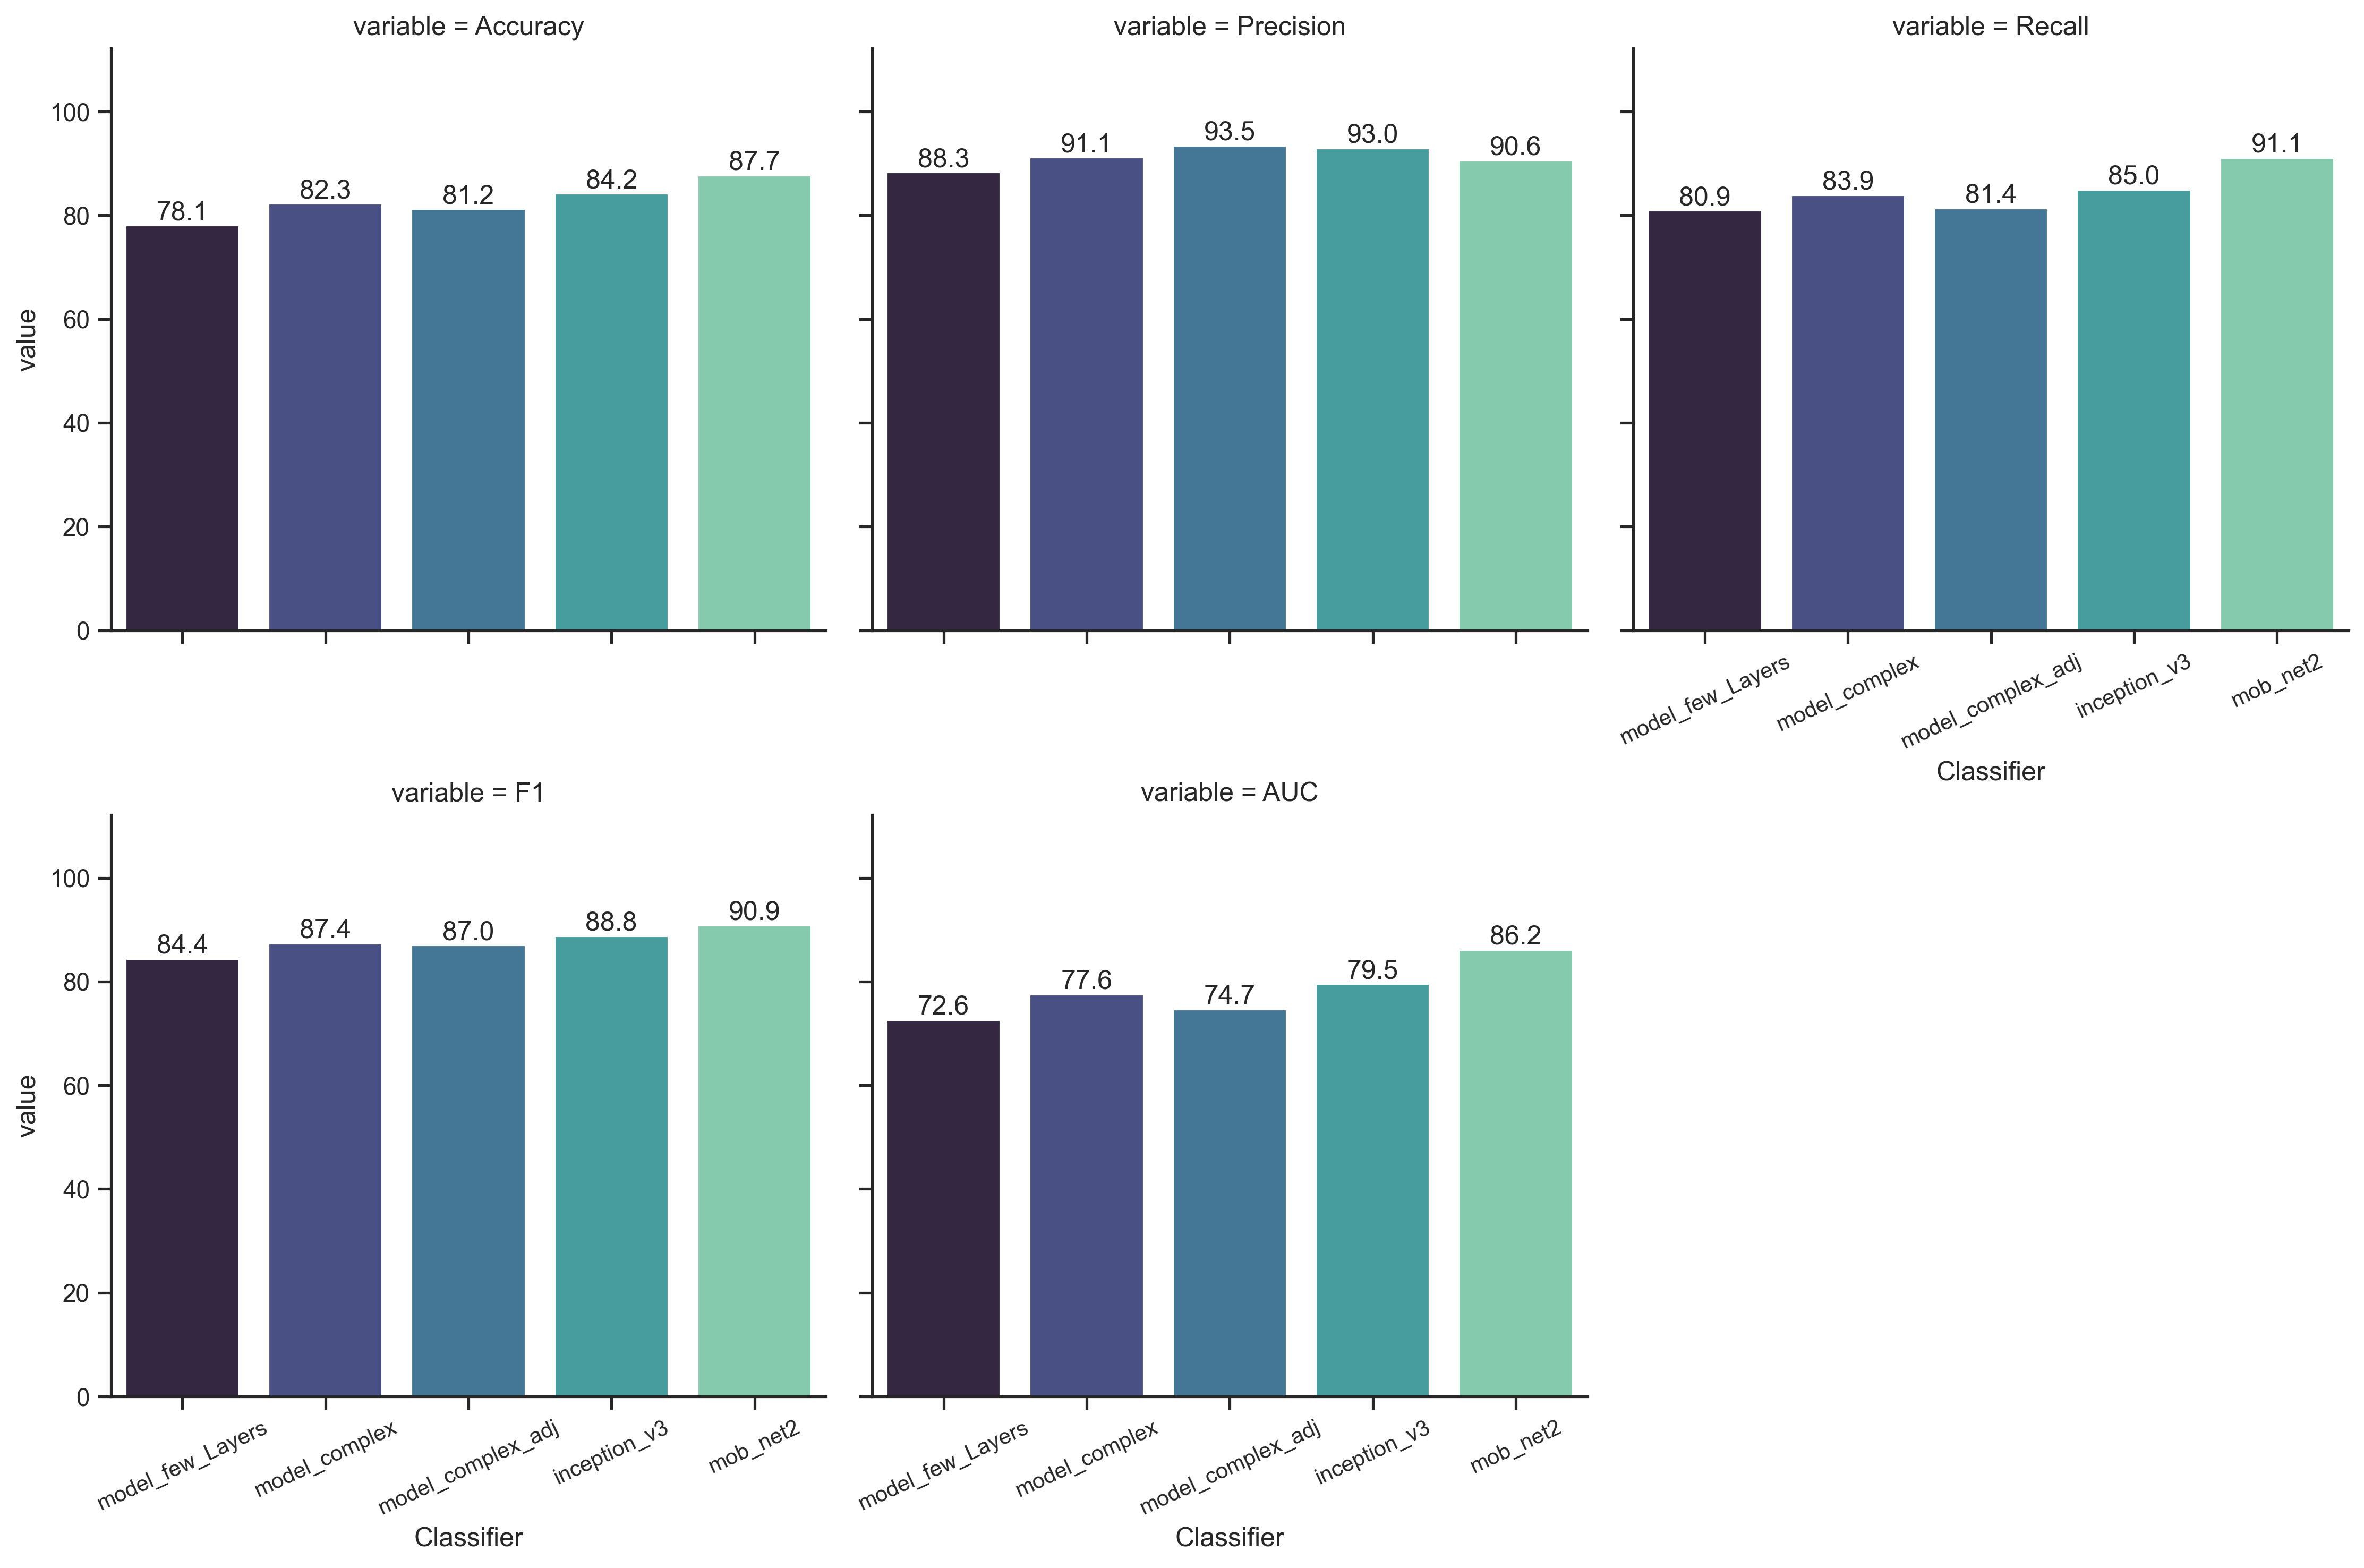

In [287]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

df2 = pd.melt(log, value_vars=[ "Accuracy", "Precision", "Recall", "F1", "AUC"], id_vars="Classifier")

#sns.set(style="ticks")

g = sns.catplot(data=df2,
                   kind="bar",
                   col="variable", # we have 1 plot per variable, forming 1 line and 5 columns (5 different variables)
                   x="Classifier", # in each plot the x-axis will be the name
                   y="value", # the height of the bar
                   col_wrap=3,# we actually want your line of plots to contain 3 plots maximum 
                   palette="mako", #Set2,Paired
                  )

# adding labels to bars
for ax in g.axes.ravel():
    for c in ax.containers:
        labels = [f'{(v.get_height()):.1f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)
 
g.set_xticklabels(fontsize=10, rotation=25) # rotate the labels so they don't overlap
plt.tight_layout() # fit everything into the figure


### Plot Area Under Curve

In [ ]:
from sklearn import metrics

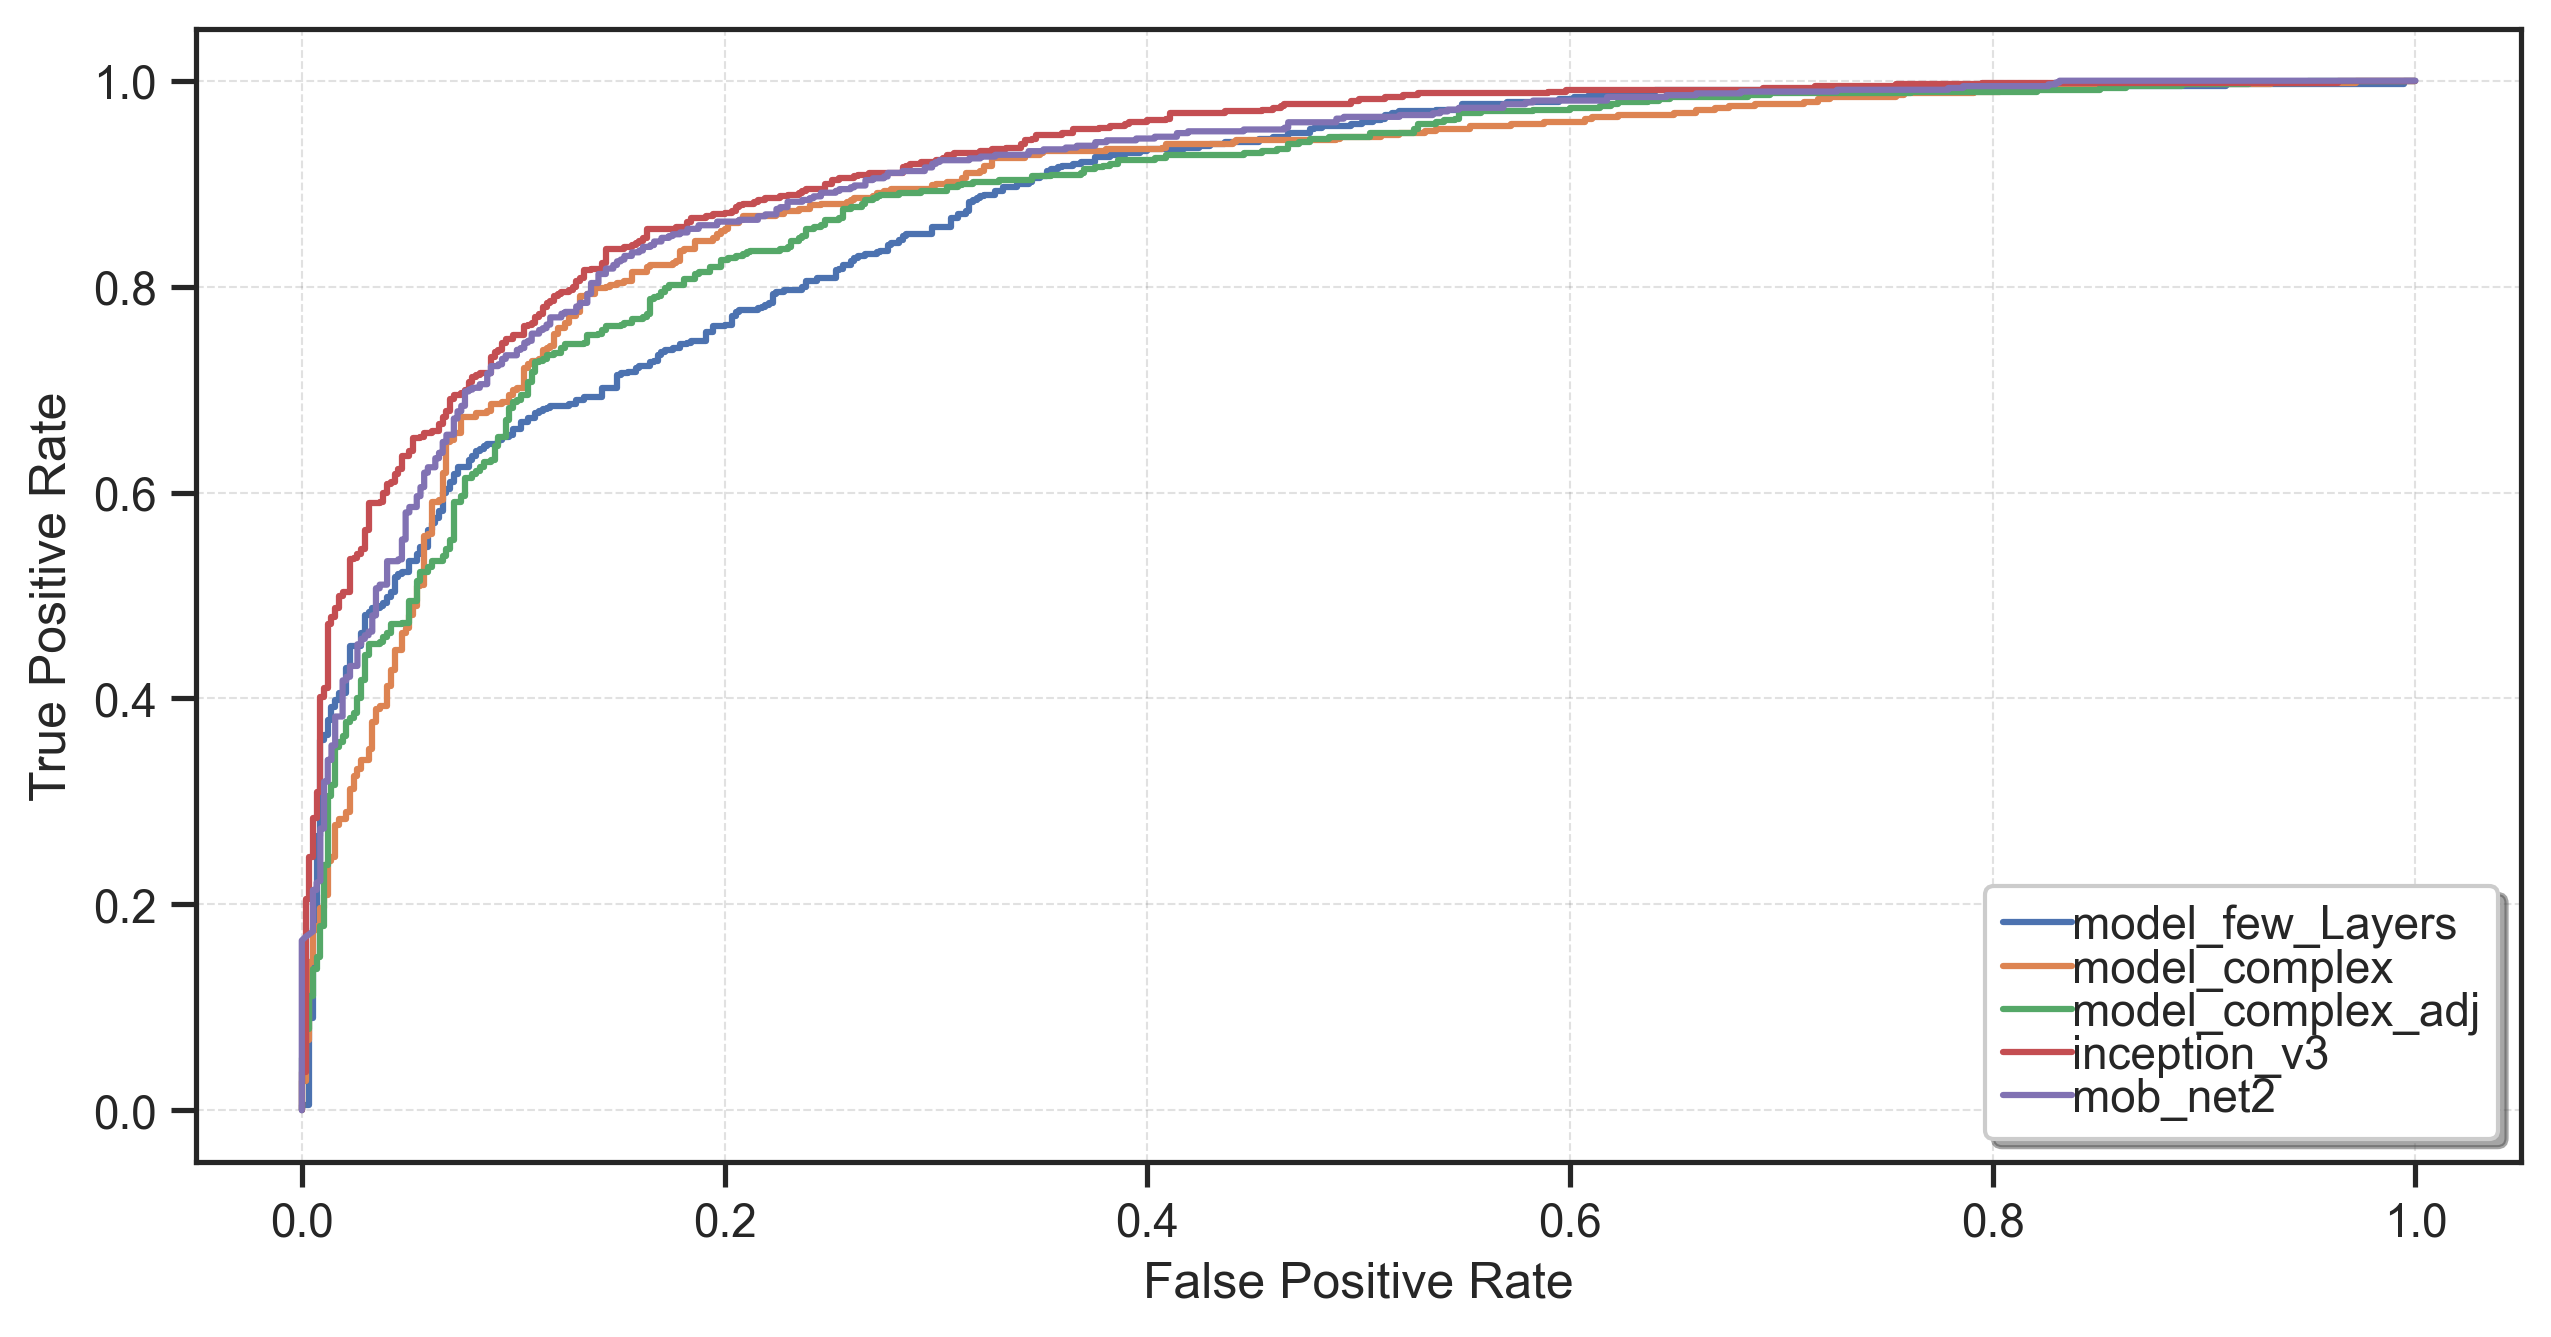

In [288]:
i=0
labels=[]

# Figure Size
plt.subplots(figsize =(10, 5))

# Add x, y gridlines
plt.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 0.5,
        alpha = 0.2)

# Plot several different AUC
for clf in classifiers:

  name = name_of_model[i]
   
  i+=1    
 
  pred = clf.predict(X_test, verbose = 0).ravel() # Predict prob and get Class Indices
  
   # calculate roc curves
  ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test.ravel(), pred)
  
   # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='-', label=name)
  labels.append(name)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(labels, 
          columnspacing=1.0, 
          labelspacing=0.0,
          handletextpad=0.0, 
          handlelength=1.5,
          fancybox=True,
          shadow=True)
   
# show the plot
plt.show()

### Accuracy vs False Negative Rate

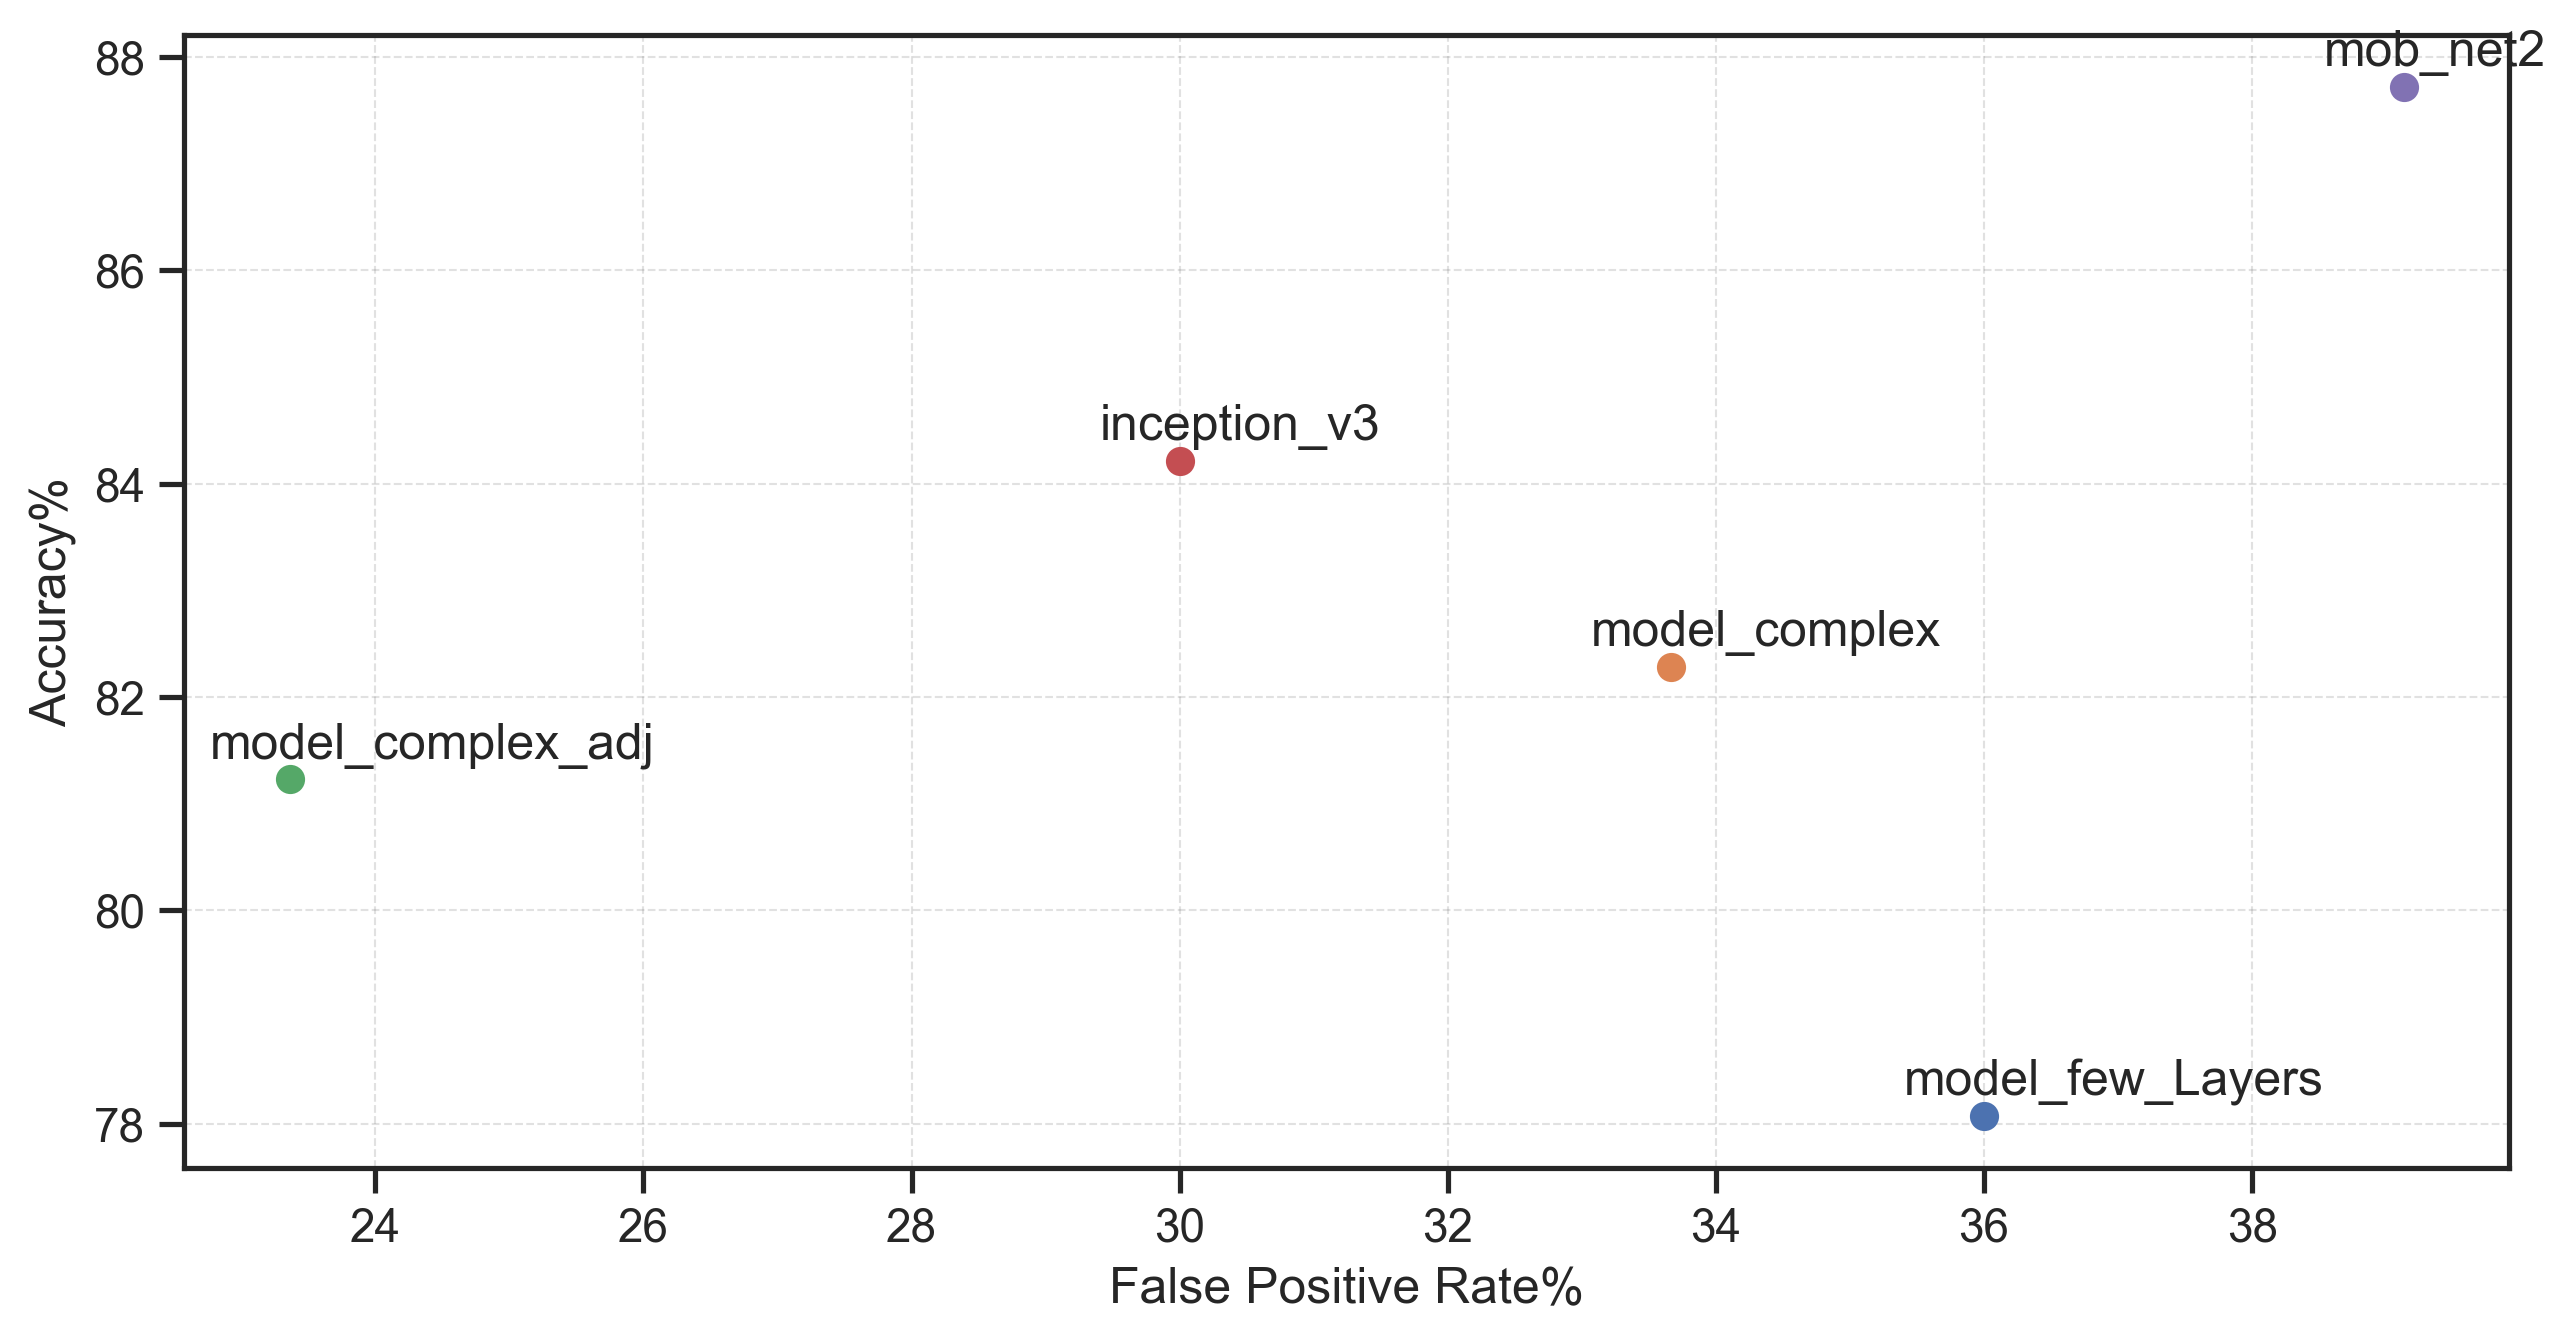

In [290]:
i=0
labels=[]

# Figure Size
plt.subplots(figsize =(10, 5))

# Add x, y gridlines
plt.grid(visible = True, color ='dimgrey',
        linestyle = '--', linewidth = 0.5,
        alpha = 0.2)

# Plot several different AUC
for clf in classifiers:

  name = name_of_model[i]
   
  i+=1    

  y_true = np.argmax(y_test, axis = 1)[:]
  pred = clf.predict(X_test, verbose = 0) # Predict prob and get Class Indices
  y_pred= np.argmax(pred, axis = 1)[:]
  cf = confusion_matrix(y_true, y_pred)
  fpr = (cf[1][0] / ( cf[1][0] + cf[0][1] ))*100
  acc = log.loc[log['Classifier']==name,'Accuracy']
  
  plt.scatter(fpr, acc)#, label=name)
  #labels.append(name)

  plt.annotate(name, (fpr-0.6, acc+0.2))
  
# axis labels
plt.xlabel('False Positive Rate%')
plt.ylabel('Accuracy%')
#plt.legend(labels, 
          # columnspacing=1.0, 
          # labelspacing=0.0,
          # handletextpad=0.0, 
          # handlelength=1.5,
          # fancybox=True,
          # shadow=True)
   
# show the plot
plt.show()

### Showcase

45

## Appendix

* Bounding box on head

In [239]:
cropped_imgs = []

for xml_path in list_annotations:
    try:    
        with urlopen(xml_path) as my_xml:
        
            xmld = xmltodict.parse(my_xml)
            tags = xmld['annotation']

            img_path = prefix_url_imgs + tags['filename']
            img_url = requests.get(img_path)
            img_temp = Image.open(BytesIO(img_url.content))
            image = cv2.cvtColor(np.array(img_temp), cv2.INPAINT_TELEA)
            helmet = np.zeros(image.shape, dtype = 'int32')

            if 'object' in tags:

                if isinstance(tags['object'], list):
                    for i in tags['object']:
                        xmin = int(i['bndbox']['xmin'])
                        ymin = int(i['bndbox']['ymin'])
                        xmax = int(i['bndbox']['xmax'])
                        ymax = int(i['bndbox']['ymax'])
                        if i['name'] == 'With Helmet':
                            helmet = cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                            result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3) #with helmet -> 1
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path])
                            #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                            
                        else:
                            cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                            result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                            cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path]) #without helmet -> 0
                            
                            #plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                if isinstance(tags['object'], dict):
                    xmin = int(tags['object']['bndbox']['xmin'])
                    ymin = int(tags['object']['bndbox']['ymin'])
                    xmax = int(tags['object']['bndbox']['xmax'])
                    ymax = int(tags['object']['bndbox']['ymax'])
                    if tags['object']['name'] == 'With Helmet':
                        cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (0,255,0), -1)
                        result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 1, img_path]) #with helmet -> 1
                        #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
                    else:
                        cv2.rectangle(helmet, (xmin,ymin), (xmax,ymax), (255,0,0), -1)
                        result = cv2.addWeighted(image, 1, helmet, 0.9, 0.7, dtype = cv2.CV_8UC3)
                        cropped_imgs.append([tags['filename'], image[ymin:ymax, xmin:xmax], 0, img_path]) #without helmet -> 0
                    # plt.imsave(os.path.join('results', tags['filename']), result)
                    #visualize(image=image, result = result, head = image[ymin:ymax, xmin:xmax])
            else:
                pass
    except:
        pass

In [248]:
from tensorflow.keras.preprocessing.image import array_to_img
all_cropped_imgs_v2 = []
for i in range(1, len(cropped_imgs)):
    try:
        img_temp = array_to_img(cropped_imgs[i][1])
        resized = img_temp.resize((240,240)) # resize all images to 40x40
        image = cv2.cvtColor(np.array(resized), cv2.INPAINT_TELEA)
        all_cropped_imgs_v2.append([cropped_imgs[i][0], image, cropped_imgs[i][2], cropped_imgs[i][3]])
    except:
        pass

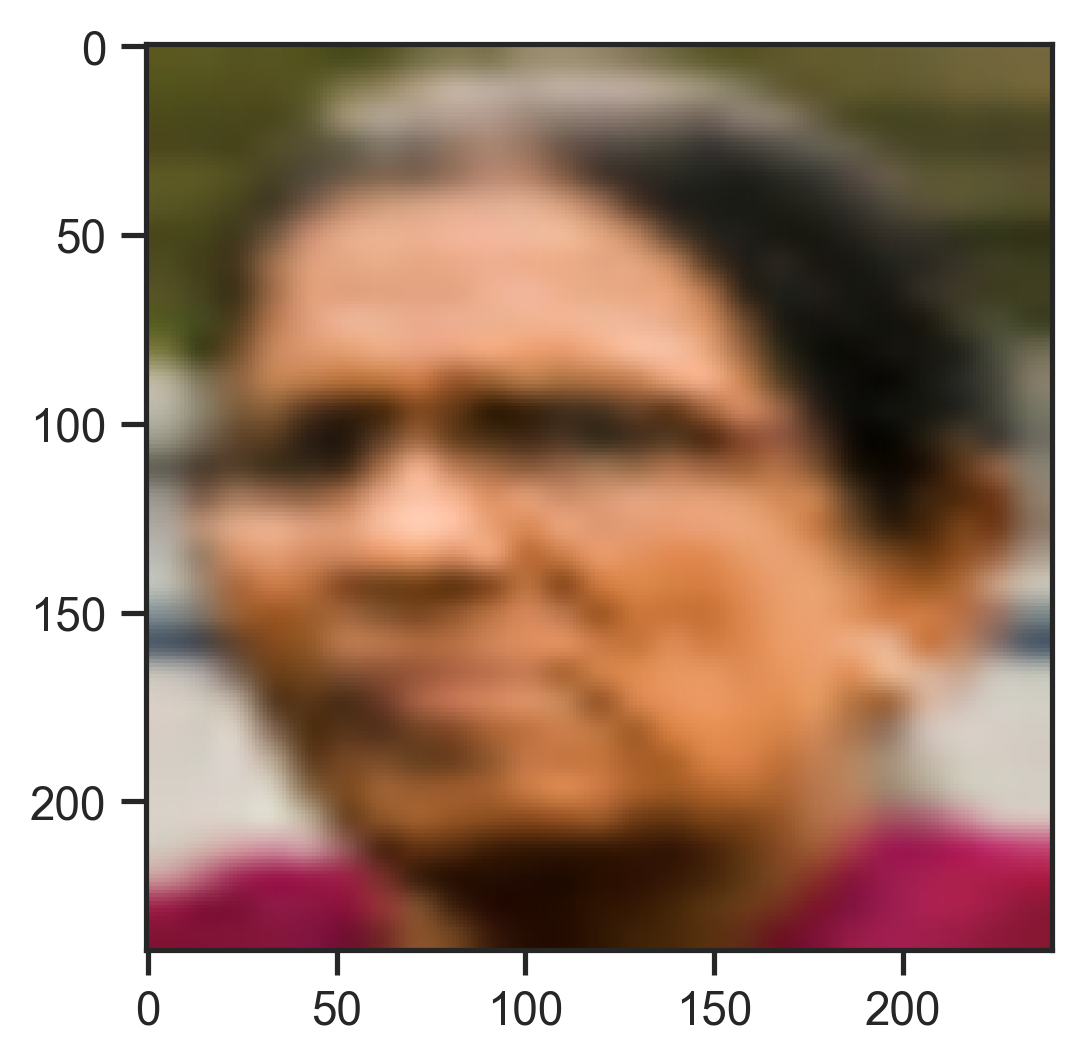

In [273]:
plt.imshow(all_cropped_imgs_v2[140][1], interpolation='nearest')

In [251]:
# Transforming images in a proper array for model input
cropped_imgs_array = []
for i in range(0, len(all_cropped_imgs_v2)):
    cropped_imgs_array.append(np.array(all_cropped_imgs_v2[i][1]))
    
cropped_imgs_array = np.array(cropped_imgs_array, dtype='int')

# Creating an array with labels
labels_array_cropped = []
for i in range(0, len(all_cropped_imgs_v2)):
    labels_array_cropped.append(np.array(all_cropped_imgs_v2[i][2]))
    
labels_array_cropped = np.array(labels_array_cropped, dtype='int')

# Categorically encode the labels
cropped_imgs_labels = to_categorical(labels_array_cropped)

In [256]:
data_cropped = tf.keras.applications.mobilenet_v2.preprocess_input(cropped_imgs_array)

In [258]:
cropped_results = mob_net2.predict(data_cropped, verbose = 0)

In [268]:
y_true_cropped = np.argmax(cropped_imgs_labels, axis = 1)[:]
y_pred_cropped= np.argmax(cropped_results, axis = 1)[:]

In [271]:
acc_cropped = accuracy_score(y_pred_cropped[:], y_true_cropped[:])
acc_cropped

0.6769016050244243

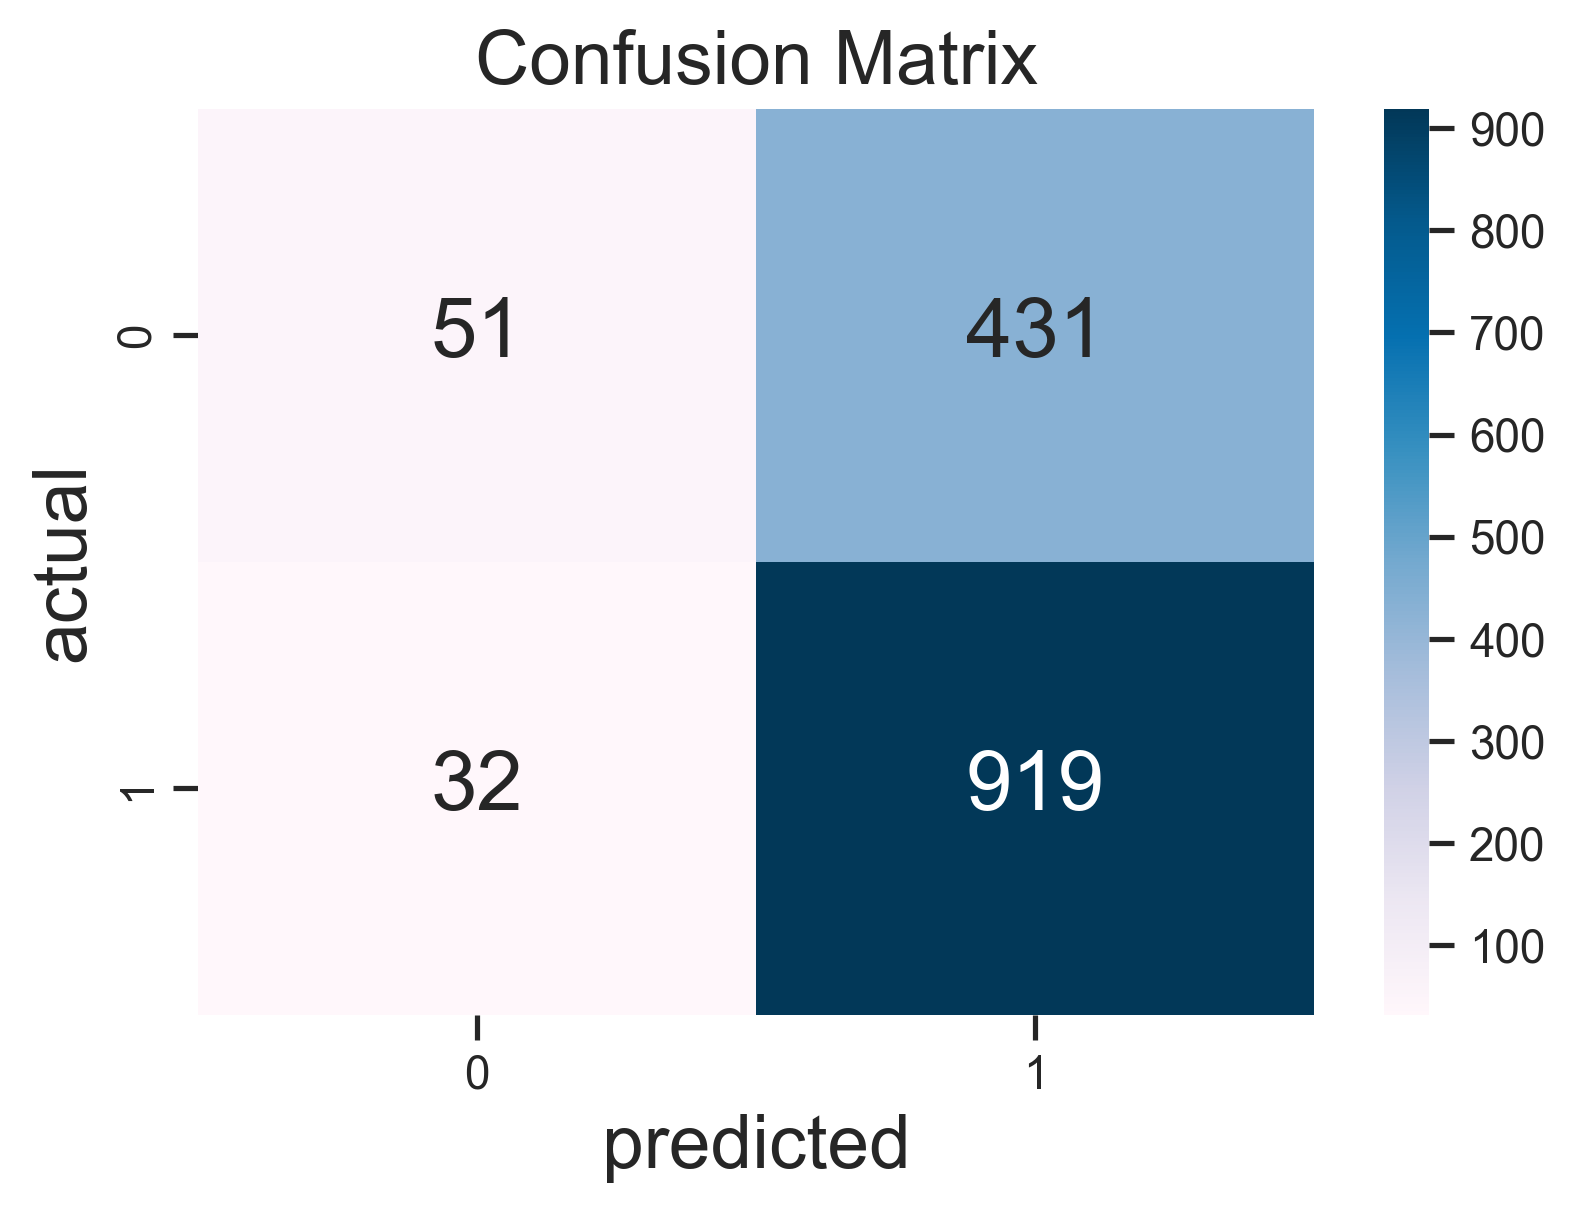

In [269]:
# confusion matrix
evaluation(y_true_cropped, y_pred_cropped)